# Analysis of Split ECG latent space for Model Poisoning Detection

In [1]:
import numpy as np
import os
from torch.nn.functional import max_pool1d, avg_pool1d
import torch
import pickle
import pandas as pd
import scipy.spatial as sp
from scipy.interpolate import make_interp_spline, BSpline
from scipy.special import kl_div, rel_entr
from scipy.stats import skewnorm, norm
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.decomposition import PCA
from functools import partial
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from contextlib import closing
import itertools
#from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import math
from server.security.analysis import *
import client.utils as utils
%load_ext autoreload
%autoreload 2

In [251]:
epochs = 30
num_clients = 10
N = 10
M = 8
p = 0.75
iid = True
base_path = f"/home/mohkoh/projects/Split_ECG_Classification/latent_space/IID={iid}_N={N}_M={M}_type=LF_p={p}"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))

epoch = 5
kde_params = {
    "kernel": "gaussian",
    #"metric": "seuclidean",
    "bandwidth": .4
}
pca_params = {
    "n_components": 24
}

knn_params = {
    "n_neighbors": 500, 
    "metric": "euclidean"
}

ref = 0

sigma = 3.0

split="knn_10_euclidean"
# split="dec"
pooling="max"
        
metadata

{'num_clients': 10,
 'exp_name': 'N=10_M=8_type=LF_p=0.75',
 'is_malicious': {0: False,
  1: True,
  2: True,
  3: True,
  4: True,
  5: False,
  6: True,
  7: True,
  8: True,
  9: True},
 'batchsize': 64,
 'data_poisoning_prob': 0.0,
 'label_flipping_prob': 0.75}

In [252]:
def load_dataframe(args):
    base_path, epoch = args
    return pd.read_pickle(os.path.join(base_path, "epoch_{}.pickle".format(epoch)))

args = [(base_path, epoch) for epoch in range(1, epochs+1)]

# Use Pool to parallelize
with multiprocessing.Pool() as p:
    list_of_dfs = list(tqdm(p.imap(load_dataframe, args), total=N, desc="Load Data Frames"))

# Combine dataframes
df_base = pd.concat(list_of_dfs, axis=0, ignore_index=True)
df_base = df_base[df_base.label.apply(sum) != 0]

Load Data Frames:   0%|          | 0/10 [00:00<?, ?it/s]

## Unimportant


In [46]:
num_clients = df_base.client_id.nunique()
P_y0 = [.9] * num_clients
client_id, epoch, ref = 0, 5, None

# Let the epoch be t = 1 
df_t = df_base[(df_base["epoch"] == epoch) & (df_base["stage"] == "train") & (df_base["client_id"] == client_id)].copy()
df_t = split_labels(df_t, split)
df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
df_t.reset_index(drop=True, inplace=True)

# The latent space Z_t is the output of each client at epoch t 
Z = np.array(df_t.client_output.to_list())
Y = df_t.label.to_numpy()
C = df_t.client_id.to_numpy()
    
# neigh = KNeighborsClassifier(**knn_params)
# neigh.fit(Z_t, y)
# dX, nX = neigh.kneighbors(Z_t, return_distance=True)

# # P(Z | Y = 0)
# P_zy_0 = kernel_membership(nX, dX, y, mal=False)
# # P_zy_0 = simple_membership(nX, y, mal=False)

# # P(Z | Y = 1)
# P_zy_1 = kernel_membership(nX, dX, y, mal=True)
# # P_zy_1 = simple_membership(nX, y, mal=True)
# #print(P_zy_0.sum(), ",", P_zy_1.sum())

# # P(Z)
# P_zy_0 = P_zy_0 * P_y0[client_id]
# P_zy_1 = P_zy_1 * (1 - P_y0[client_id])
# P_z = P_zy_0.sum() + P_zy_1.sum()

# # P(Y = 0 | Z)
# P_yz_0 = P_zy_0 / P_z

# # P(Y = 1 | Z)
# P_yz_1 = P_zy_1 / P_z

In [47]:
Z0, Y0, C0 = Z, Y, C

In [94]:
Z0.shape

(1920, 24)

In [59]:
Z0[Y0 == 8].shape

(48, 24)

In [55]:
kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(Z0[Y0 == 16])
np.exp(kde.score_samples(Z1[Y1 == 8])).sum()

1.9949257415788366e-21

In [56]:
np.exp(kde.score_samples(Z2[Y2 == 8])).sum()

4.389286782213197e-21

In [57]:
np.exp(kde.score_samples(Z0[Y0 == 8])).sum()

1.575035729448955e-17

In [163]:
D_all = sp.distance.pdist(Z, "seuclidean")

In [40]:
idx = lambda i,j: Z.shape[0] * i + j - ((i + 2) * (i + 1)) // 2

In [164]:
def D(i, c, y):
    C_i = np.delete(C, i, axis=0)
    Y_i = np.delete(Y, i, axis=0)
    D_i = D_all[idx(i, 1):idx(i, Z.shape[0])]
    D_ic = D_i[np.where(C_i == c)]
    Y_ic = Y_i[np.where(C_i == c)]
    
    delta = Y_ic == Y[i]
        
    h = D_ic[delta].std() / 2
    
    delta = delta == y
    N = delta.sum()
    
    D_ic = D_ic[delta]
    D_ic = np.exp(-D_ic / h)
    
    density = np.sum(D_ic) / N
    
    return density

In [180]:
def P(i):
    a = [D(i=i, c=c, y=True) for c in range(num_clients)]
    b = [D(i=i, c=c, y=False) for c in range(num_clients)]
    c = [a[i] + b[i] for i in range(len(a))]
    a = [a[i] / c[i] for i in range(len(a))]
    b = [b[i] / c[i] for i in range(len(b))]
    return a, b

In [184]:
P(800)

([0.5825396987001099,
  0.512355023500546,
  0.4734093657102364,
  0.4912557816344979,
  0.4591308272007209,
  0.3650500395490258,
  0.42053420949337056,
  0.4252111629958949,
  0.5580856831514097,
  0.4690067441216527],
 [0.4174603012998901,
  0.48764497649945393,
  0.5265906342897636,
  0.5087442183655021,
  0.5408691727992792,
  0.6349499604509741,
  0.5794657905066295,
  0.574788837004105,
  0.44191431684859034,
  0.5309932558783473])

In [173]:
i = 0

a = [D(i=i, c=c, y=True) for i in np.where(C == 0)[0]]
print(sum([D(i=i, c=c, y=True) for i in np.where(C == 0)[0]]))
print(sum([D(i=i, c=c, y=False) for i in np.where(C == 0)[0]]))


78.75480946584148
77.9000913483384


In [133]:
def naive_bayes2(epoch, theta):

    # Let the epoch be t = 1 
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()

    for client_id in range(num_clients):
        df_t_c = df_t[df_t["client_id"] == client_id].copy()
        df_t_c = split_labels(df_t_c, split)
        df_t = df_t[df_t["client_id"] != client_id]
        df_t = pd.concat([df_t, df_t_c], ignore_index=True)

    df_t.reset_index(drop=True, inplace=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    Y = df_t.label.to_numpy().astype(int)
    C = df_t.client_id.to_numpy()
    
    # Gets the k-nearest neighbors for each point in the latent space Z, regardless of the client.
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z, Y)
    dX, nX = neigh.kneighbors(Z, return_distance=True)
    
    # Automatically calculates the bandwidth for each point based on the std of the distance to points from the same class
    dY = dX[:, 1:]
    nY = Y[nX]
    dY_k = dY * (nY == Y[:, None])
    dY = dY ** 2
    sigma = np.nanstd(np.where(np.isclose(dY_k,0), np.nan, dY_k)) #dY_k.std(axis=1)[:, None]

    # Applies gaussian exponential kernel
    dY = np.exp(-(dY) / 2*(sigma))

    # Normalizes based on sigma and hypersphere volume
    dY = dY/ dY.shape[1] * sigma

    # Reweighs based on prior about the client trustability
    nC = theta[C[nX]]
    dY = dY * nC

    # Calculates trustability 
    p_0 = (dY * (nY != Y[:, None])).sum(axis=1)
    p_1 = (dY * (nY == Y[:, None])).sum(axis=1)
    
    for client_id in range(theta.shape[0]):
        theta[client_id] = (p_1[C == client_id].sum() / (p_0[C == client_id].sum() + p_1[C == client_id].sum())) * theta[client_id]

    return theta

In [ ]:
def naive_bayes2(epoch, theta):

    # Let the epoch be t = 1 
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    Y = np.array(df_t.label.to_list())
    #Y_dec = (Y * 2**np.arange(Y.shape[-1])[::-1]).sum(axis=1)
    C = df_t.client_id.to_numpy()

    # Gets the k-nearest neighbors for each point in the latent space Z, regardless of the client.
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z, Y)
    dX, nX = neigh.kneighbors(Z, return_distance=True)


    dY = dX
    nY = ((Y[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
    #dY = dY ** 2

    # Automatically calculates the bandwidth for each point based on the std of the distance to points from the same class
    dY_k = dY * (nY > 0)
    dY_k_m = dY_k.sum(axis=1) / (nY > 0).sum(axis=1) #mean 
    dY_k = np.abs(dY_k - dY_k_m[:, None])
    sigma = dY_k.sum(axis=1) / (nY > 0).sum(axis=1) #std 
    sigma = sigma[:, None]


    # Applies gaussian exponential kernel
    dY = np.exp(-(dY ** 2) / 2*(sigma))
    dY = np.nan_to_num(dY, nan=0, posinf=0, neginf=0)

    # Normalizes based on sigma and hypersphere volume
    dY = dY/ dY.shape[1] * 1.0

    # Reweighs based on prior about the client trustability
    nC = theta[C[nX]][:, 1:]
    dY = dY * nC

    # Calculates trustability 
    p_0 = (dY * (nY == 0)).sum(axis=1)
    p_1 = (dY * (nY > 0)).sum(axis=1)
    
    for client_id in range(theta.shape[0]):
        theta[client_id] = (p_1[C == client_id].sum() / (p_0[C == client_id].sum() + p_1[C == client_id].sum()))

    return theta

In [63]:
def simple_membership(nX, y, mal=False):
    nY = y[nX]
    comp = nY[:, 0]
    
    if mal:
        p_k = (nY != comp[:, None]).sum(axis=1) - 1
    else:
        p_k = (nY == comp[:, None]).sum(axis=1) - 1
        
    p_k = p_k / (nX.shape[1] - 1)
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

def kernel_membership(nX, dX, y, mal=0):
    #dY = np.exp(-(dX)[:, 1:] ** 2 / sigma ** 2)
    dY = dX[:, 1:]
    nY = y[nX]
    comp = nY[:, 0]
    nY = nY[:, 1:]
    
    dY = dY ** 2
    dY_k = dY * (nY != comp[:, None])
    sigma = dY_k.std(axis=1)[:, None]
    
    dY = np.exp(-(dY) / 2*(sigma))
    
    if mal:
        p_k = (dY * (nY != comp[:, None])).sum(axis=1)
    else:
        p_k = (dY * (nY == comp[:, None])).sum(axis=1)
    
    #p_k = p_k / dY.sum(axis=1)
    #p_k = p_k / np.sum(p_k)
    p_k = np.nan_to_num(p_k, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

def naive_bayes(client_id, epoch, P_y0, ref=None):

    # Let the epoch be t = 1 
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == client_id) & (df_base["stage"] == "train")].copy()
    
    if ref is not None:
        df_ref = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == ref) & (df_base["stage"] == "train")].copy()
        df_t = pd.concat([df_t, df_ref], ignore_index=True)
        
    df_t = split_labels(df_t, split)
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t.reset_index(drop=True, inplace=True)

    # The latent space Z_t is the output of each client at epoch t 
    Z_t = np.array(df_t.client_output.to_list())
    y = df_t.label.to_numpy()
    #client_ids = df_t.client_id.to_numpy()
        
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z_t, y)
    dX, nX = neigh.kneighbors(Z_t, return_distance=True)

    # P(Z | Y = 0)
    P_zy_0 = kernel_membership(nX, dX, y, mal=False)
    # P_zy_0 = simple_membership(nX, y, mal=False)

    # P(Z | Y = 1)
    P_zy_1 = kernel_membership(nX, dX, y, mal=True)
    # P_zy_1 = simple_membership(nX, y, mal=True)
    #print(P_zy_0.sum(), ",", P_zy_1.sum())

    # P(Z)
    P_zy_0 = P_zy_0 * P_y0[client_id]
    P_zy_1 = P_zy_1 * (1 - P_y0[client_id])
    P_z = P_zy_0.sum() + P_zy_1.sum()

    # P(Y = 0 | Z)
    P_yz_0 = P_zy_0 / P_z

    # P(Y = 1 | Z)
    P_yz_1 = P_zy_1 / P_z

    return client_id, P_yz_0.sum(), P_yz_1.sum()

## P(y|z) = P(z|y)P(y) / P(z)

Compare at the end of each epoch considering the whole latent space. 

In [7]:
def simple_membership(nX, y, mal=False):
    nY = y[nX]
    comp = nY[:, 0]
    
    if mal:
        p_k = (nY != comp[:, None]).sum(axis=1) - 1
    else:
        p_k = (nY == comp[:, None]).sum(axis=1) - 1
        
    p_k = p_k / (nX.shape[1] - 1)
    # p_k = {k: p_k[y == k].mean() for k in np.unique(y)}
    # p_k = [p_k[y == k].mean() for k in np.unique(y)]
    # p_k = p_k / np.sum(p_k)
    # p_k = {k: p_k[i] for i, k in enumerate(np.unique(y))}
    return p_k

def kernel_membership(nX, dX, y):
    dY = dX[:, 1:]
    nY = ((y[nX] == 1) & (y[:, None] == 1)).sum(axis=2)[:, 1:]
    nY = (nY > 0)
    #dY = dY ** 2

    # Automatically calculates the bandwidth for each point based on the std of the distance to points from the same class
    sigma = dY.std(axis=1)[:, None]
    dY_k = dY * nY
    # dY_k_m = dY_k.sum(axis=1) / (nY > 0).sum(axis=1) #mean 
    # dY_k = np.abs(dY_k - dY_k_m[:, None])
    # sigma = dY_k.sum(axis=1) / (nY > 0).sum(axis=1) #std 
    # sigma = sigma[:, None]
    sigma_k = dY_k.std(axis=1)[:, None]
    sigma_zero = np.where(sigma_k == 0)
    sigma_k[sigma_zero] = sigma[sigma_zero]
    sigma = sigma_k


    # Applies gaussian exponential kernel
    dY = np.exp(-(dY ** 2) / (sigma))
    dY = np.nan_to_num(dY, nan=0, posinf=0, neginf=0)

    # Normalizes based on sigma and hypersphere volume
    dY = dY/ dY.shape[1] * 1.0

    # Reweighs based on prior about the client trustability
    # nC = theta[C[nX]][:, 1:]
    # dY = dY * nC
    
    p_0 = (dY * nY)
    p_1 = (dY * ~nY)
    
    return p_0.sum(axis=1), p_1.sum(axis=1)

def naive_bayes(client_id, epoch, P_y0, ref=None):

    # Let the epoch be t = 1 
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == client_id) & (df_base["stage"] == "train")].copy()
    
    if ref is not None:
        df_ref = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == ref) & (df_base["stage"] == "train")].copy()
        df_t = pd.concat([df_t, df_ref], ignore_index=True)
    elif ref == -1:
        if not epoch == 1 and client_id == 0:
            ref = (client_id - 1) % df_t.client_id.nunique()
            t = epoch - (client_id == 0)
            df_ref = df_base[(df_base["epoch"] == t) & (df_base["client_id"] == ref) & (df_base["stage"] == "train")].copy()
            df_t = pd.concat([df_t, df_ref], ignore_index=True)
        
        
    #df_t = split_labels(df_t, split)
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t.reset_index(drop=True, inplace=True)

    # The latent space Z_t is the output of each client at epoch t 
    Z_t = np.array(df_t.client_output.to_list())
    Z_t = np.c_[Z_t, df_t.loss.values.astype(np.float32)**2]
    y = np.array(df_t.label.to_list())
    #client_ids = df_t.client_id.to_numpy()
        
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z_t, y)
    dX, nX = neigh.kneighbors(Z_t, return_distance=True)
    
    # P(Z | Y = 0, P(Z | Y = 1)
    P_zy_0, P_zy_1 = kernel_membership(nX, dX, y)

    # P(Z)
    P_zy_0 = P_zy_0 * P_y0[client_id]
    P_zy_1 = P_zy_1 * (1 - P_y0[client_id])
    P_z = P_zy_0.sum() + P_zy_1.sum()

    # P(Y = 0 | Z)
    P_yz_0 = P_zy_0 / P_z

    # P(Y = 1 | Z)
    P_yz_1 = P_zy_1 / P_z

    return client_id, P_yz_0.sum(), P_yz_1.sum()

## Experiment: Using whole latent space

In [213]:
# Get Z for each epoch fast
def get_Z(epoch):
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    Y = np.array(df_t.label.to_list())
    #Y_dec = (Y * 2**np.arange(Y.shape[-1])[::-1]).sum(axis=1)
    C = df_t.client_id.to_numpy()

    # Gets the k-nearest neighbors for each point in the latent space Z, regardless of the client.
    neigh = KNeighborsClassifier(**knn_params)
    neigh.fit(Z, Y)
    dX, nX = neigh.kneighbors(Z, return_distance=True)
    
    return C, Y, dX, nX, epoch

def get_all_Z(epochs):
    Z_all = {}

    with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count() // 2)) as p:
        for r in tqdm(p.imap_unordered(get_Z, range(1, epochs + 1)), total=epochs):
            Z_all[r[-1]] = r[:-1]
            
    return Z_all

In [7]:
Z_IID = get_all_Z(epochs)

In [214]:
Z_NON_IID = get_all_Z(epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

In [227]:
def naive_bayes3(theta, C, Y, dX, nX):
    # Y = Y[C == client_id]
    # dX = dX[C == client_id]
    # nX = nX[C == client_id]
    
    dY = dX[:, 1:]
    nY = ((Y[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
    nY = (nY > 0)
    #dY = dY ** 2
    
    # Reweigh based on class balance
    # cw = 1 - class_weights
    # cw = cw / cw.sum()
    # cw = class_weights
    # weights = (Y[nX] * cw).sum(axis=2)[:, 1:]

    # Automatically calculates the bandwidth for each point based on the std of the distance to points from the same class
    # --- MIN SIGMA
    dY_k = dY * nY
    dY_k[dY_k == 0] = np.inf
    sigma = dY_k.min(axis=1)[:, None] ** 2
    sigma = np.nan_to_num(sigma, nan=0, posinf=0, neginf=0)
    
    
    # --- dY_k std (1)
    # dY_k = dY * nY
    # sigma = pd.Series(dY_k.tolist())
    # sigma = sigma.apply(lambda x: np.array(x)).apply(lambda x: x[x != 0])
    # sigma = sigma.apply(lambda x: np.array([0]) if len(x) == 0 else x)
    # sigma = sigma.apply(lambda x: x.std()).values[:, None]
    # sigma_ = dY.std(axis=1)[:, None]
    # sigma[sigma == 0] = sigma_[sigma == 0] #np.sqrt(sigma_[sigma == 0])
    
    # --- dY_k std (2)
    # dY_k = dY * nY
    # sigma = dY_k.std(axis=1)[:, None]
    # sigma_ = dY.std(axis=1)[:, None]
    # sigma[sigma == 0] = sigma_[sigma == 0]
    
    # --- simple sigma
    # sigma = dY.std(axis=1)[:, None]


    # Applies gaussian exponential kernel
    dY = np.exp(-(dY ** 2) / sigma)
    # dY = dY * weights


    # Normalizes based on sigma and hypersphere volume
    dY = dY/ dY.shape[1] * 1.0

    # Calculates trustability 
    p_1 = (dY * ~nY)
    p_0 = (dY * nY)
    
    # Reweighs based on prior about the client trustability
    # theta_ = 1 - theta
    # p_1 = p_1 * theta[C[nX]][:, 1:]
    # p_0 = p_0 * theta[C[nX]][:, 1:]
    
    for client_id in range(theta.shape[0]):
        p_0_c, p_1_c = p_0[C == client_id], p_1[C == client_id]
        p_0_c, p_1_c = p_0_c * theta[client_id], p_1_c * (1 - theta[client_id]) 
        theta[client_id] = (p_0_c.sum() / (p_0_c.sum() + p_1_c.sum()))
        
        # if client_id == 8:
        #     p_0_8.append(p_0_c)
        #     p_1_8.append(p_1_c)
            

    return theta

theta = np.array([0.5]*10)
num_clients = 10
# Z_all = Z_IID
Z_all = Z_NON_IID
df_probs = pd.DataFrame(columns=["epoch", "client_id", "prob_y0", "prob_y1"])
for epoch in tqdm(range(1, epochs + 1), total=epochs):
    theta = naive_bayes3(theta, *Z_all[epoch])
    for client_id in range(num_clients):
        df_probs.loc[len(df_probs)] = [epoch, client_id, theta[client_id], 1 - theta[client_id]]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.exp(-(dY ** 2) / sigma)
/tmp/ipykernel_3298766/1984990302.py:45: RuntimeWarning: divide by zero encountered in divide
  dY = np.

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

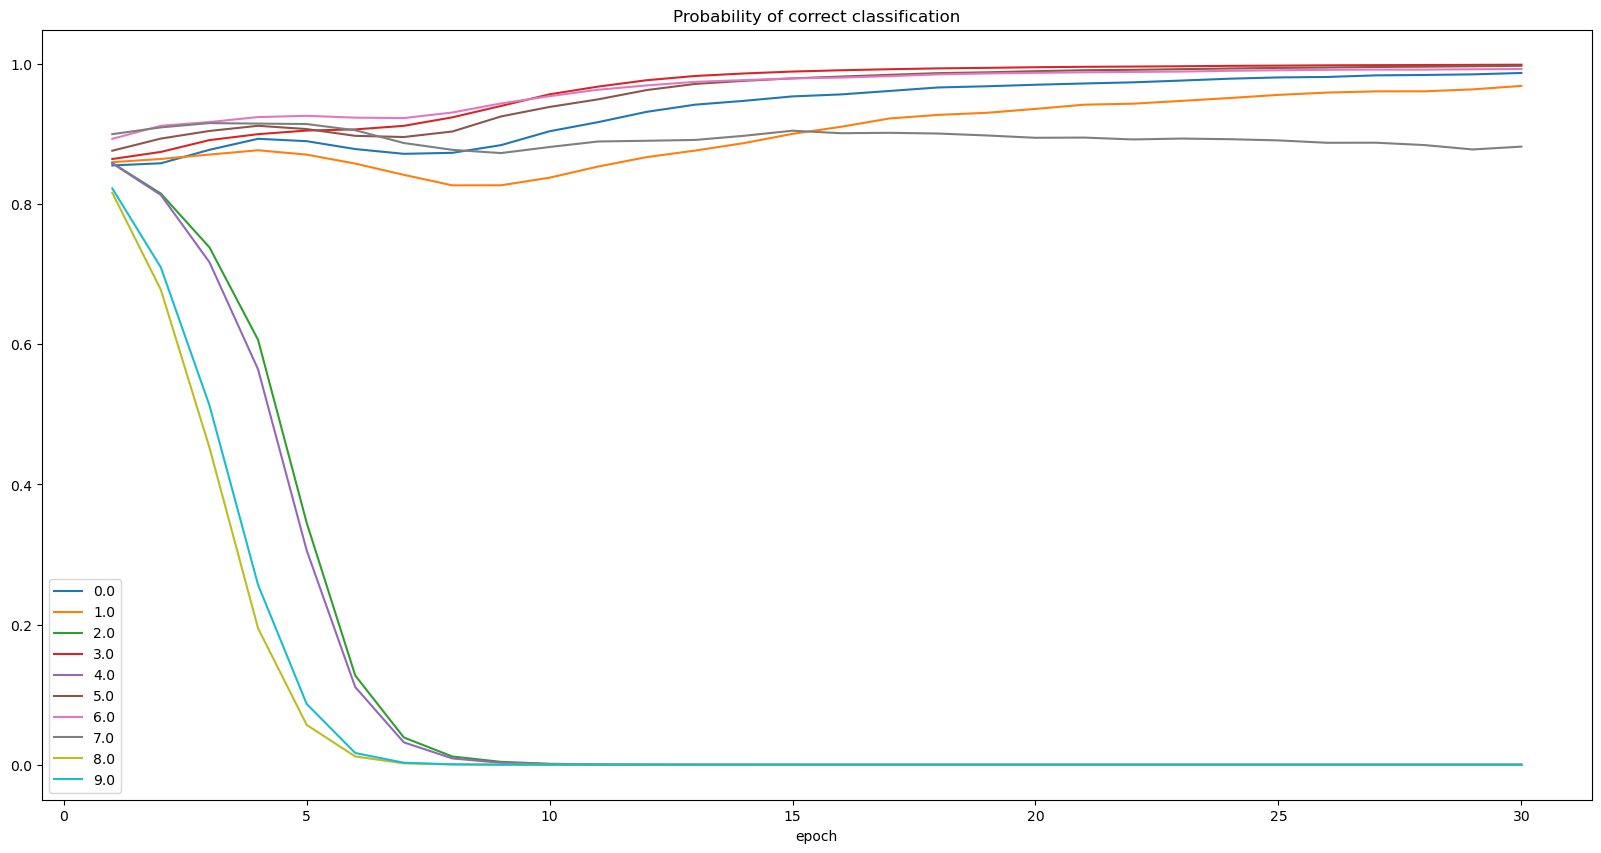

In [372]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

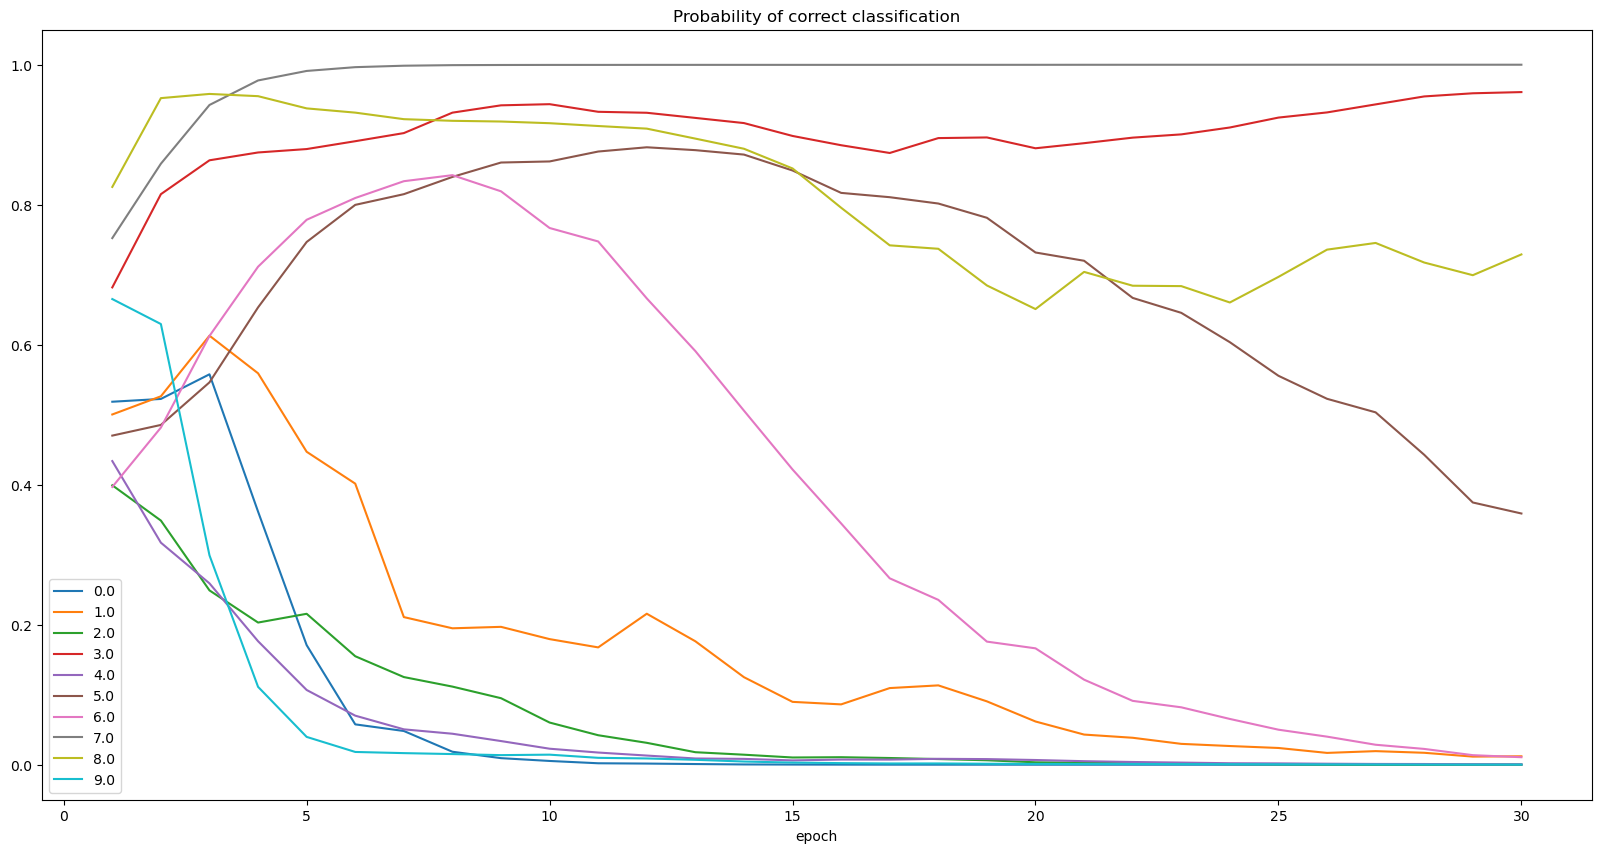

In [218]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

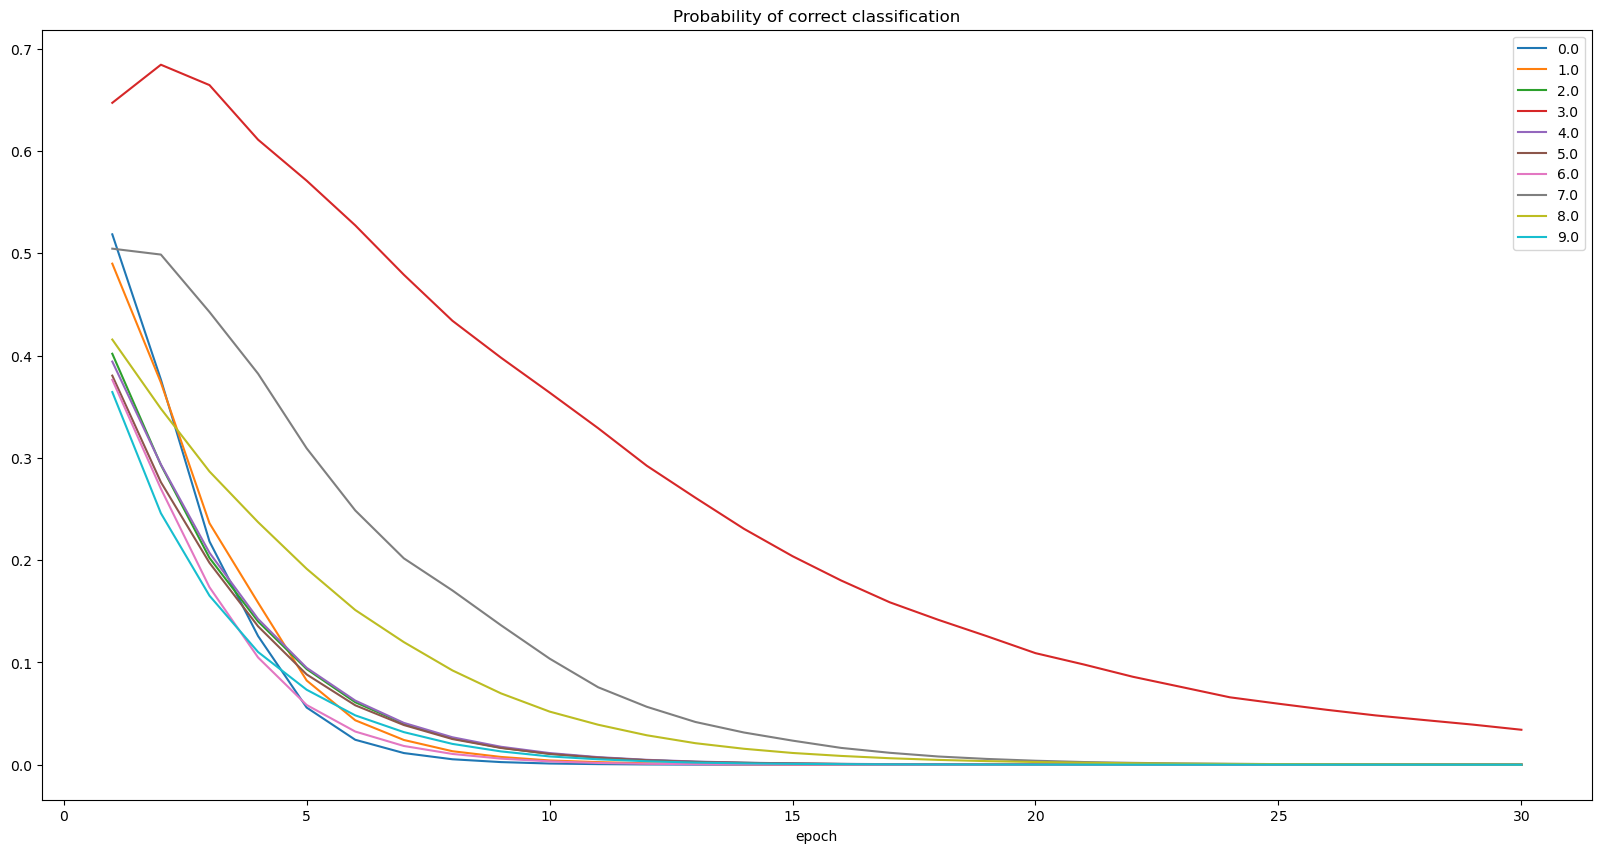

In [228]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

### Analysing the failing client $c_8$

In [13]:
# Epoch 3 where the probability is rising fast for c_8
e = 15
for c in [2, 4, 8, 9]:
# for c in [0, 1, 3, 5, 6, 7]:
    C, Y, dX, nX = Z_NON_IID[e]
    nY = ((Y[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
    Y = Y[C == c]
    nY = nY[C == c]
    dX = dX[C == c]
    nX = nX[C == c]
    cw = Y[:, None].sum(axis=0)
    dY = dX[:, 1:]
    nY_ = nY
    nY = (nY > 0)
    sigma = dY.std(axis=1)[:, None]
    dY_tmp = dY_k = dY * nY
    dY_tmp2 = dY_k_m = dY_k.sum(axis=1) / nY.sum(axis=1) #mean 
    dY_k = np.abs(dY_k - dY_k_m[:, None])
    dY_tmp2 = sigma_k = dY_k.sum(axis=1) / nY.sum(axis=1) #std 
    sigma_k = sigma_k[:, None]
    sigma_k = np.nan_to_num(sigma_k, nan=0, posinf=0, neginf=0)
    # sigma_k = dY_k.std(axis=1)[:, None]
    sigma_zero = np.where(sigma_k == 0)
    sigma_k[sigma_zero] = sigma[sigma_zero]
    sigma = sigma_k
    sigma = dY.std(axis=1)[:, None]


    # Applies gaussian exponential kernel
    dY = np.exp(-(dY ** 2) / 2*sigma**2)
    #print(np.around(cw / cw.sum(), 2))
    
    #class_probs = [(dY * nY)[Y[:, k] == 1].sum() / ((dY * nY)[Y[:, k] == 1].sum() + (dY * ~nY)[Y[:, k] == 1].sum()) for k in [0, 1, 2, 3, 4]]
    # np.around(class_probs, 2), 
    
    print((dY * nY).sum() / ((dY * nY).sum() + (dY * ~nY).sum()), (~nY.sum(axis=1) - nY.sum(axis=1)).mean(), (nY.argmin(axis=1).mean()))

0.3976366751134454 -79.67798913043478 0.8063858695652174
0.3957889507058051 -79.29241071428571 0.7295386904761905
0.44364471674891737 -87.27717391304348 1.080163043478261
0.39040634743129343 -78.16927083333333 0.7493489583333334


/tmp/ipykernel_3298766/264813157.py:17: RuntimeWarning: invalid value encountered in divide
  dY_tmp2 = dY_k_m = dY_k.sum(axis=1) / nY.sum(axis=1) #mean


In [179]:
for c in [0, 1, 3, 5, 6, 7]:
    C, Y, dX, nX = Z_NON_IID[10]
    nY = ((Y[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
    Y = Y[C == c]
    nY = nY[C == c]
    dX = dX[C == c]
    nX = nX[C == c]
    cw = Y[:, None].sum(axis=0)
    dY = dX[:, 1:]
    nY = (nY > 0)
    sigma = dY.std(axis=1)[:, None]
    dY_k = dY * nY
    dY_k_m = dY_k.sum(axis=1) / nY.sum(axis=1) #mean 
    dY_k = np.abs(dY_k - dY_k_m[:, None])
    sigma_k = dY_k.sum(axis=1) / nY.sum(axis=1) #std 
    sigma_k = sigma_k[:, None]
    sigma_k = np.nan_to_num(sigma_k, nan=0, posinf=0, neginf=0)
    # sigma_k = dY_k.std(axis=1)[:, None]
    # sigma_zero = np.where(sigma_k == 0)
    # sigma_k[sigma_zero] = sigma[sigma_zero]
    sigma = sigma_k


    # Applies gaussian exponential kernel
    dY = np.exp(-(dY ** 2) / 2*sigma**2)
    #print(np.around(cw / cw.sum(), 2))
    
    class_probs = [(dY * nY)[Y[:, k] == 1].sum() / (dY * ~nY)[Y[:, k] == 1].sum() for k in [0, 1, 2, 3, 4]]
    
    print(np.around(class_probs, 2))

/tmp/ipykernel_3257992/4288567385.py:28: RuntimeWarning: invalid value encountered in scalar divide
  class_probs = [(dY * nY)[Y[:, k] == 1].sum() / (dY * ~nY)[Y[:, k] == 1].sum() for k in [0, 1, 2, 3, 4]]


[   nan    nan    nan   1.27 178.63]
[  nan   nan   nan  1.47 24.49]
[ nan  nan 0.57 1.34 0.13]
[0.75 2.67 1.2  1.34 1.63]
[2.41 1.13 1.43 3.02 1.36]
[2.19 1.39 1.73 2.98 2.66]


In [111]:
p_0_8, p_1_8 = [], []

In [120]:
C, Y, dX, nX = Z_NON_IID[3]
p_0 = p_0_8[3]
p_1 = p_1_8[3]
y_8 = Y[C == 8]

In [138]:
dX.mean(axis=1).mean()

2.914661418214802

In [133]:
idx = y_8[:, 0] == 1
p_0[idx].sum() / (p_0[idx].sum() + p_1[idx].sum())

0.9982055086084662

In [135]:
p_0.sum() / (p_0.sum() + p_1.sum())

0.9982985049589139

In [66]:
Y_all = [Z_NON_IID[e][1] for e in range(1, epochs + 1)]
Y_all = [y[:, None].sum(axis=0) for y in Y_all]
Y_sum = Y_all[0]
for y in Y_all[1:]:
    Y_sum += y
Y_sum /= len(Y_all)
class_weights = Y_sum / Y_sum.sum()
# class_weights = 1 - class_weights
# class_weights = class_weights / class_weights.sum()
class_weights

array([[0.17784145, 0.12251323, 0.20742305, 0.30237473, 0.18984754]])

In [64]:
(Y * class_weights).sum(1)

(2112, 5)

## Experiment: Using only the client's latent space

In [205]:
# Get Z for each epoch fast
def get_Z(epoch, client_id):
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == client_id) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    
    # Normalizes each sample to unit norm
    #Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)
    
    Y = np.array(df_t.label.to_list())
    #Y_dec = (Y * 2**np.arange(Y.shape[-1])[::-1]).sum(axis=1)
    C = df_t.client_id.to_numpy()
    
    knn_params_ = knn_params.copy()
    knn_params_["n_neighbors"] = Z.shape[0] // 20

    # Gets the k-nearest neighbors for each point in the latent space Z, regardless of the client.
    neigh = KNeighborsClassifier(**knn_params_)
    neigh.fit(Z, Y)
    dX, nX = neigh.kneighbors(Z, return_distance=True)
    
    return dX, nX, Y, epoch

def get_all_Z(epochs):
    Z_all = []
    for client_id in tqdm(range(num_clients)):
        Z_all.append({})
        partial_get_Z = partial(get_Z, client_id=client_id)
        with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count())) as p:
            for r in tqdm(p.imap_unordered(partial_get_Z, range(1, epochs + 1)), total=epochs, leave=True, position=0):
                Z_all[client_id][r[-1]] = r[:-1]
            
    return Z_all



In [216]:
# Get the k-NN model for the ref client's latent space
def get_ref_state(epoch, ref):
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == ref) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels 
    Z = np.array(df_t.client_output.to_list())
    
    # Normalizes each sample to unit norm
    #Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)
    
    Y = np.array(df_t.label.to_list())
    
    knn_params_ = knn_params.copy()
    knn_params_["n_neighbors"] = Z.shape[0] // 20

    # Gets the k-nearest neighbors model
    neigh = KNeighborsClassifier(**knn_params_)
    neigh.fit(Z, Y)
    
    return neigh, Z, Y

def get_observations(ref_state, client_id):
    epoch, ref_state = ref_state
    
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == client_id) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)
    
    # Latent Space with labels 
    Z = np.array(df_t.client_output.to_list())
    
    # Normalizes each sample to unit norm
    #Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)
    
    Y = np.array(df_t.label.to_list())
    
    neigh, _, Y_ref = ref_state
    
    dX, nX = neigh.kneighbors(Z, return_distance=True)
    
    return dX, nX, Y, Y_ref, epoch

def get_all_observations(epochs, ref=0):
    # List of all clients other than the ref
    clients = list(range(num_clients))
    clients.remove(ref)
    epochs_list = list(range(1, epochs + 1))
    ref_states = []
    
    # Get reference state for each epoch
    for epoch in epochs_list:
        ref_states.append(get_ref_state(epoch, ref))
    
    
    Z_all = {}
    for client_id in tqdm(clients):
        Z_all[client_id] = {}
        partial_get_observations = partial(get_observations, client_id=client_id)
        with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count())) as p:
            for r in tqdm(p.imap_unordered(partial_get_observations, zip(epochs_list, ref_states)), total=epochs, leave=True, position=0):
                Z_all[client_id][r[-1]] = r[:-1]
            
    return Z_all



In [253]:
Z_IID = get_all_observations(epochs, ref=ref)
Z_IID_old = get_all_Z(epochs)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [224]:
Z_IID_6 = get_all_observations(epochs, ref=ref)
Z_IID_6_old = get_all_Z(epochs)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [234]:
Z_non_IID = get_all_observations(epochs, ref=ref)
Z_non_IID_old = get_all_Z(epochs)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [258]:

def naive_bayes(theta, dX, nX, Y, Y_ref=None):
    if Y_ref is None:
        Y_ref = Y

    dY = dX[:, 1:]
    nY = ((Y_ref[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
    nY = (nY > 0)
    
    # normalice dY along axis 1
    dY = dY / (dY.min(axis=1)[:, None])
    
    # # --- simple sigma
    sigma = dY.std(axis=1)[:, None]
    # sigma = dY.max(axis=1)[:, None]
    # A = sigma.copy()
    # for k in range(Y.shape[1]):
    #     idx = Y[:, k] == 1
        
    #     if(idx.sum() == 0):
    #         continue
        
    #     min_k = dY[idx].std(axis=1)[:, None]
    #     iqr = np.percentile(dY[idx], 75, axis=1) - np.percentile(dY[idx], 25, axis=1)
    #     iqr = iqr[:, None] / 1.34
    #     A_k = np.minimum(min_k, iqr)
    #     sigma[idx] = np.minimum(sigma[idx], min_k)
    #     A[idx] = np.minimum(sigma[idx], A_k)
        
    iqr = np.percentile(dY, 75, axis=1) - np.percentile(dY, 25, axis=1)
    iqr = iqr[:, None] / 1.34
    A = np.min([iqr, sigma], axis=0)
    n = dY.shape[1]
    dim = 1
    
    # Scott's rule of thumb
    c = 1.059
    h_scott = c * sigma * n**(-1./(dim+4))
    
    # Silverman's rule of thumb
    c = 0.9
    h_silverman = c * A * n**(-1./(dim+4))
    
    # Trivial bandwidth
    h_trivial = sigma #2*sigma**2
    
    h = h_trivial

    # Applies gaussian exponential kernel
    dY = np.exp(-(dY**2) / (h))
    
    # mask = (dY.sum(axis=1) != 0)
    # dY = dY[mask]
    # nY = nY[mask]
    # dY = dY / dY.sum(axis=1)[:, None]
    
    test = (dY.sum(axis=1) == 0)
    if test.sum():
        print(test.sum())
        print(Y[test])

    # Calculates trustability 
    p_1 = (dY * ~nY)
    p_0 = (dY * nY)
    
    # p_0 = p_0.sum(axis=1)[:, None] / dY.sum(axis=1)[:, None]
    # p_1 = p_1.sum(axis=1)[:, None] / dY.sum(axis=1)[:, None]
    
    p_0, p_1 = p_0 * theta, p_1 * (1 - theta) 
    theta = (p_0.sum() / (p_0.sum() + p_1.sum()))
            

    return theta

theta = np.array([0.9]*10)
# Z_all, ref = Z_IID_old, None
Z_all, ref = Z_IID, 0

# Z_all, ref = Z_IID_6_old, None
# Z_all, ref = Z_IID_6, 0

# Z_all, ref = Z_non_IID_old, None
# Z_all, ref = Z_non_IID, 6


clients = list(range(num_clients))
if ref is not None:
    clients.remove(ref)

df_probs = pd.DataFrame(columns=["epoch", "client_id", "prob_y0", "prob_y1"])
for epoch in tqdm(range(1, epochs + 1), total=epochs):
    for client_id in clients:
        if epoch == 1:
            print("Len for client {} is {}".format(client_id, len(Y)))
        theta[client_id] = naive_bayes(theta[client_id], *Z_all[client_id][epoch])
        df_probs.loc[len(df_probs)] = [epoch, client_id, theta[client_id], 1 - theta[client_id]]

  0%|          | 0/30 [00:00<?, ?it/s]

Len for client 1 is 1883
Len for client 2 is 1883
Len for client 3 is 1883
Len for client 4 is 1883
Len for client 5 is 1883
Len for client 6 is 1883
Len for client 7 is 1883
Len for client 8 is 1883
Len for client 9 is 1883


client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

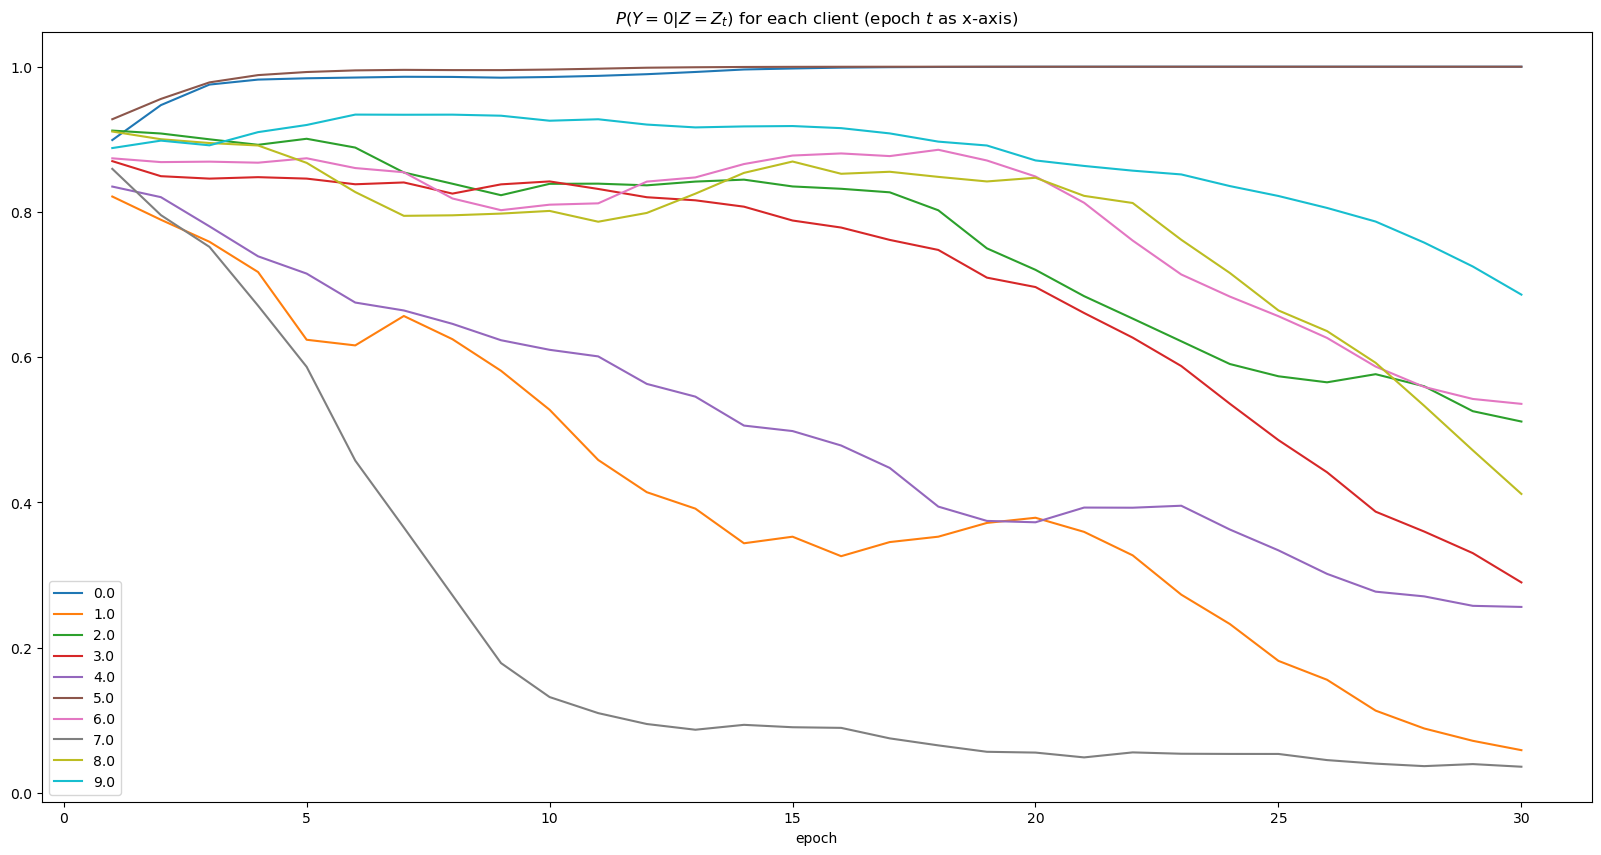

In [257]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="$P(Y=0|Z=Z_t)$ for each client (epoch $t$ as x-axis)")

client_id
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

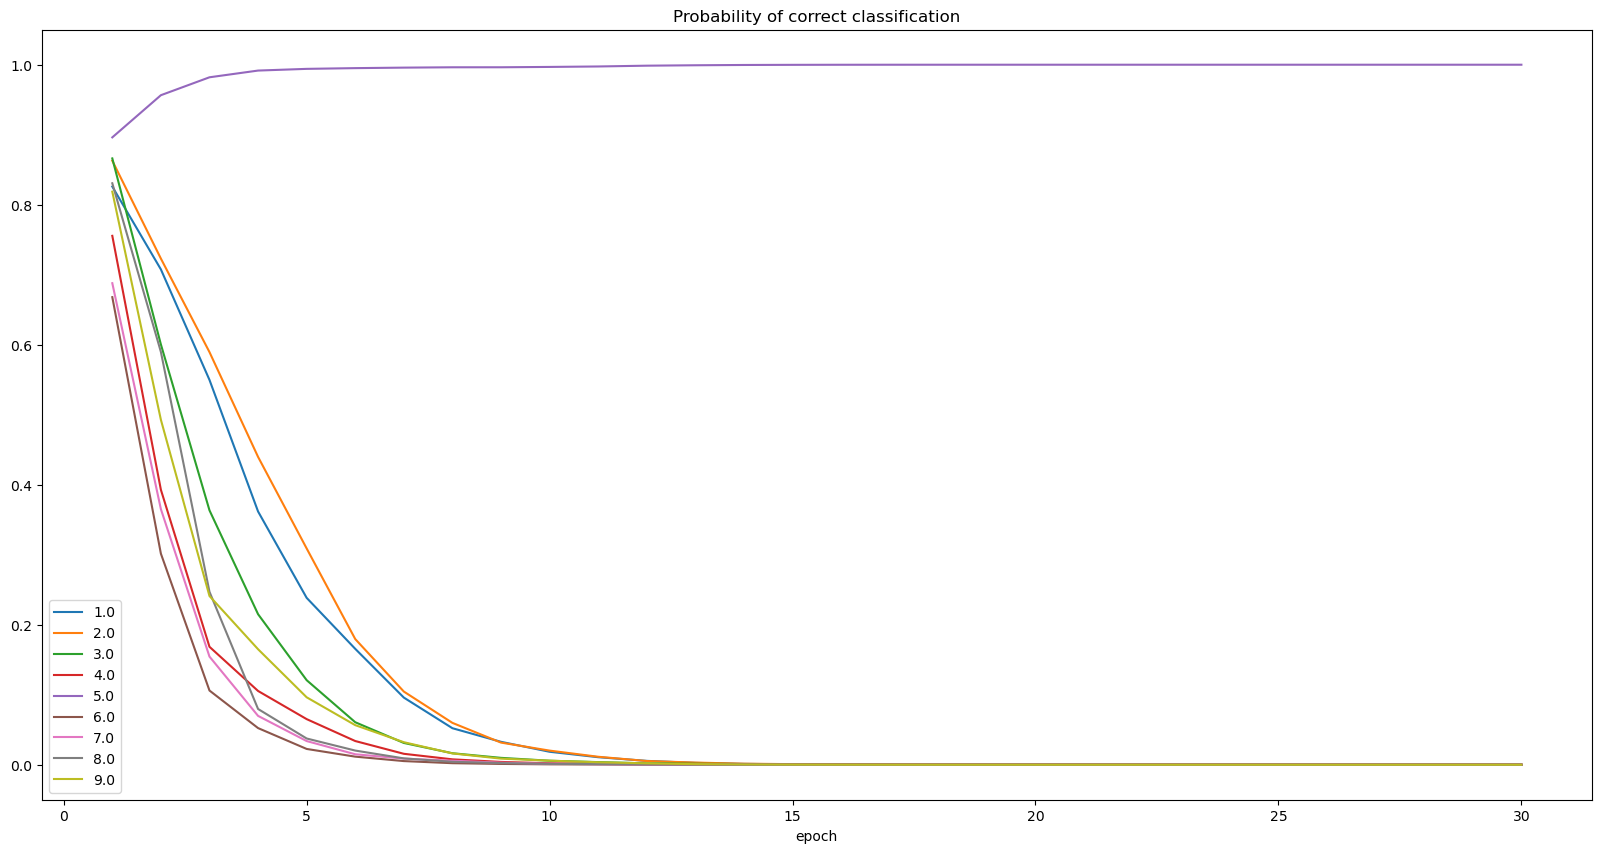

In [259]:
# sigma is the standard deviation only considering the same class, replacing 0 with std of all classes
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

client_id
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

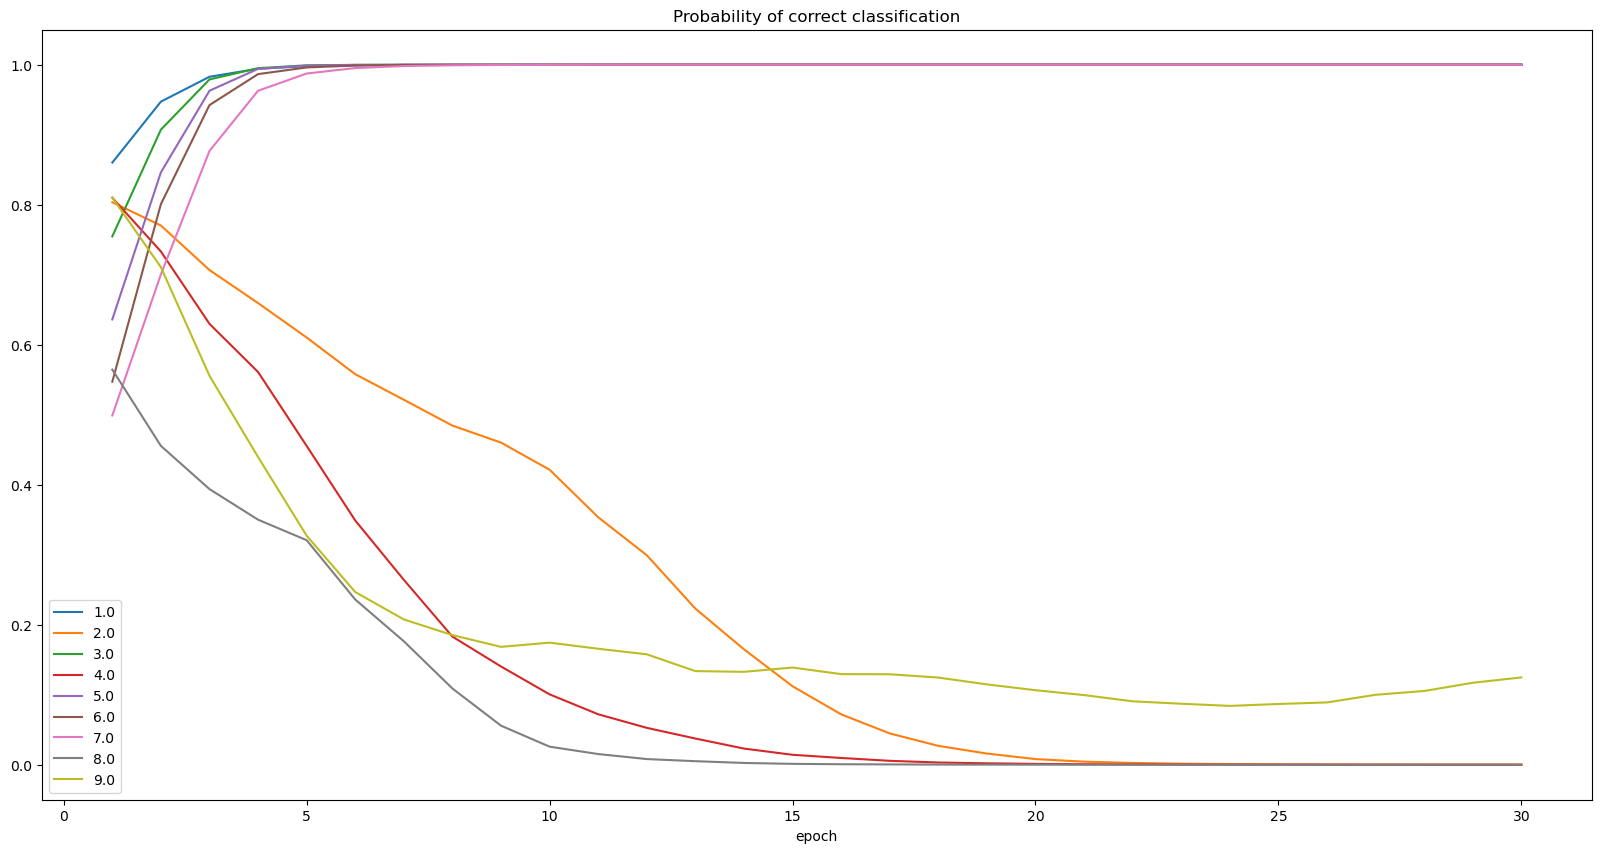

In [201]:
# sigma is the standard deviation only considering the same class, replacing 0 with std of all classes
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

client_id
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

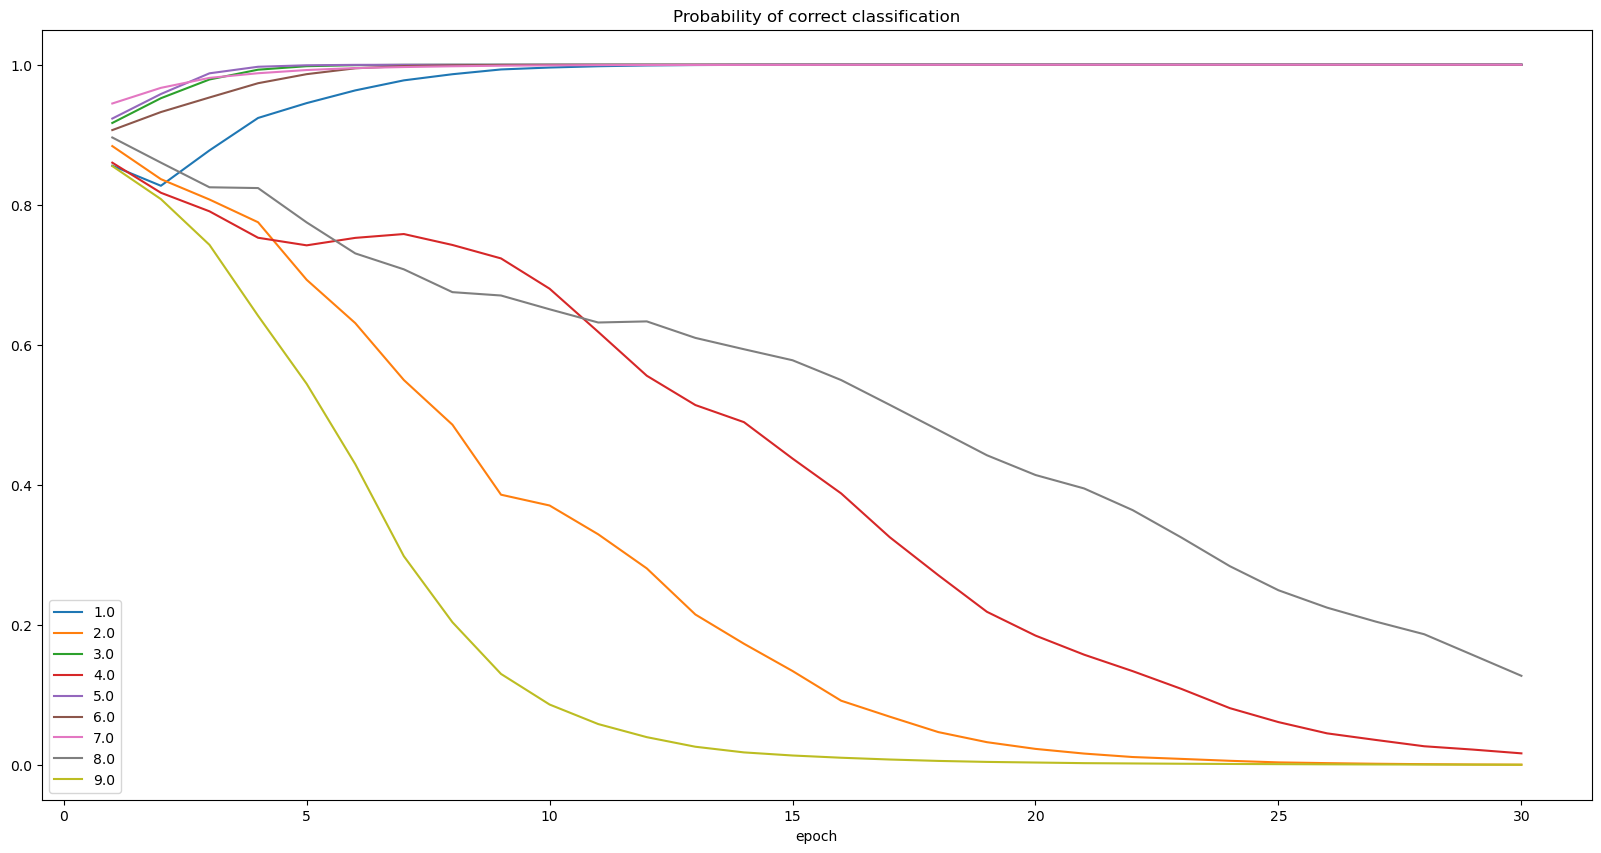

In [213]:
# sigma is std of all classes
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

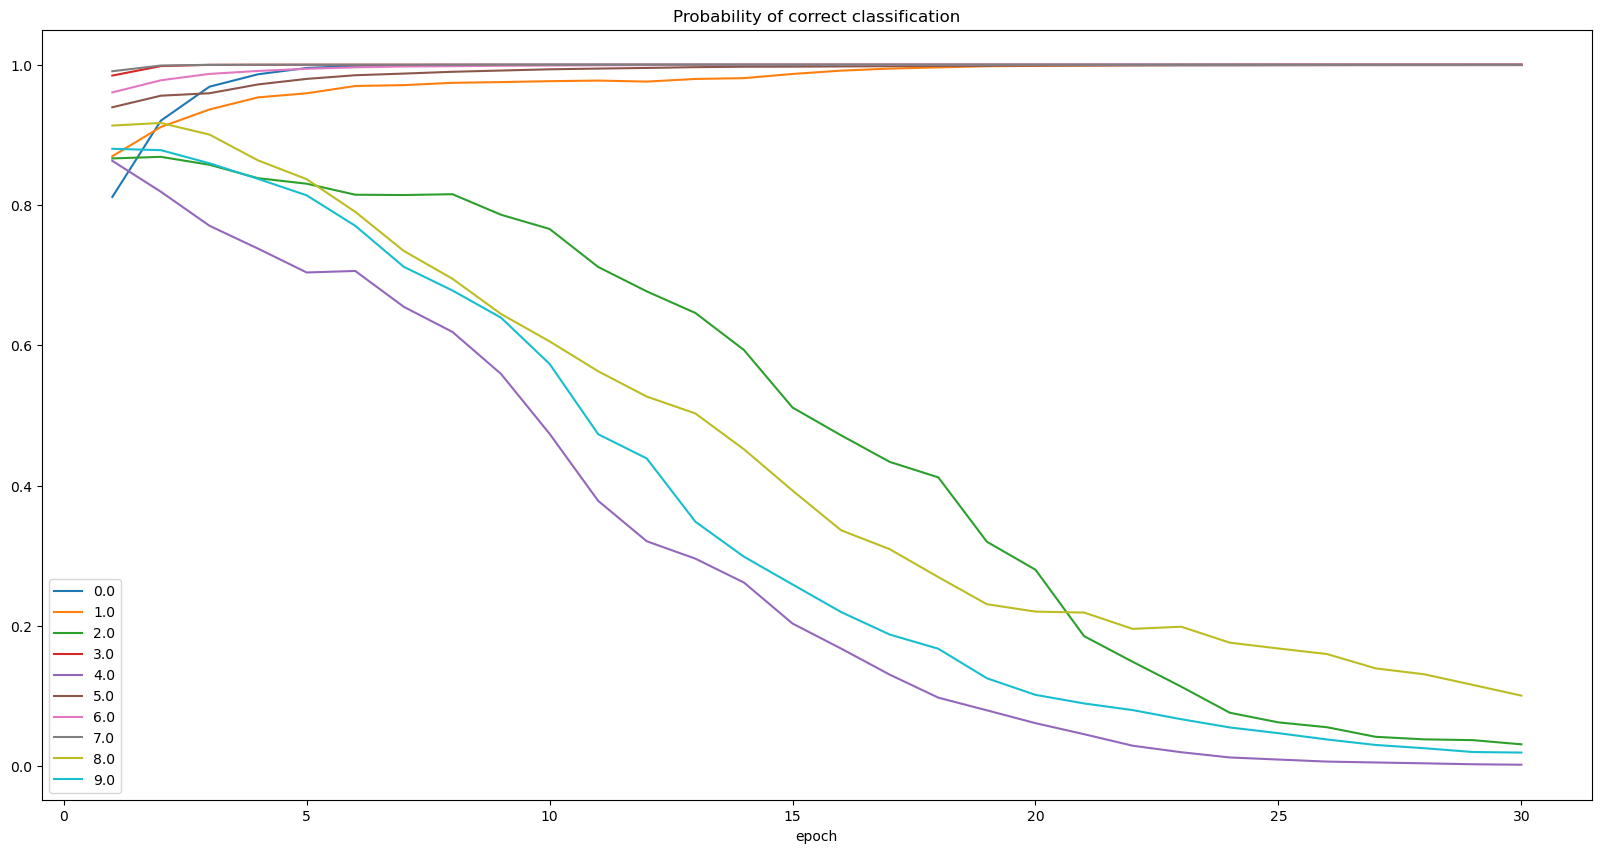

In [236]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

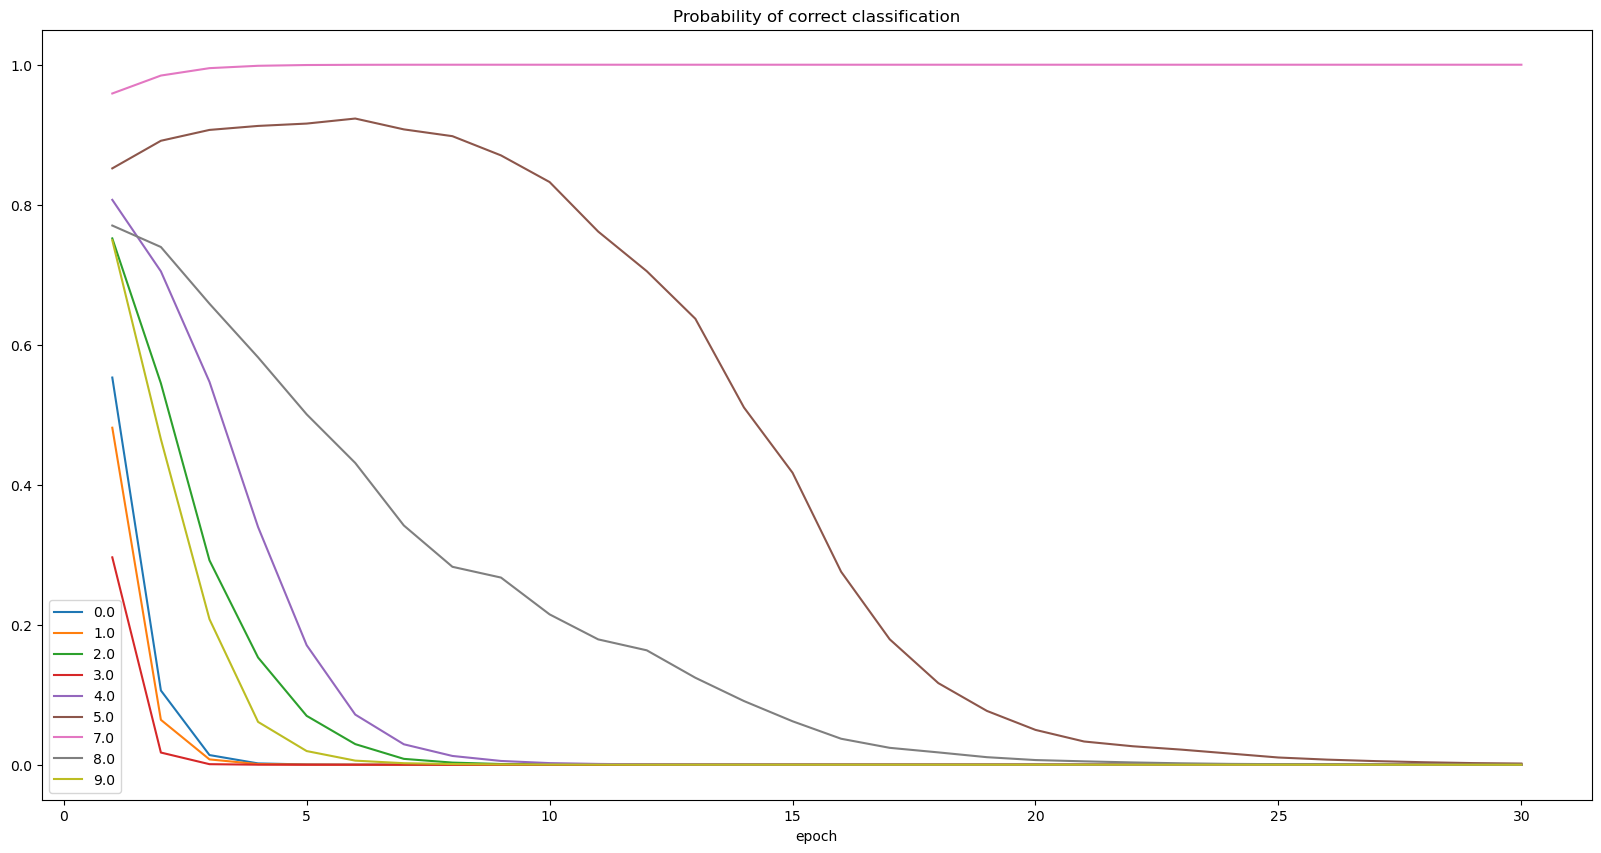

In [239]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

## Analysis: Why $c_8$ is so different than the other malicious clients?

In [354]:
def plot_neighbor_distances(Z, epoch, client, frac=0.05):
    
    C, Y, dX, nX = Z[client][epoch]

    dY = dX[:, 1:]
    #dY = dY / dY.max(axis=1)[:, None]
    nY = ((Y[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
    nY = (nY > 0)
    
    sample_size = int(dY.shape[0] // (1/frac))
    fig, ax = plt.subplots(nrows=sample_size,figsize=(20, sample_size), sharey=True)
    
    samples = np.random.choice(dY.shape[0], size=sample_size, replace=False)
    dY = dY[samples, :]
    nY = nY[samples, :]
    
    for s in range(sample_size):
        idx = range(dY.shape[1]+1)
        D = dY[s, :]
        sigma = D.std()
        D = [sigma] + D.tolist()
        bar_labels = nY[s,:].astype(int)
        bar_labels = [-1] + bar_labels.tolist()
        bar_colors = ["green" if x == 1 else "red" for x in bar_labels]
        bar_colors[0] = "blue"

        ax[s].bar(idx, D, label=bar_labels, color=bar_colors)

        ax[s].set_ylabel('d')

    plt.show()

In [133]:
Z = Z_IID

e = 5
c = [2, 3, 9, 8]

Z = [Z_IID[i][e] for i in c]

C, Y, dX, nX = Z[3][:-1]

idx = Y[:, 1] == 1

dY = dX[:, 1:]
#dY = dY / dY.max(axis=1)[:, None]
nY = ((Y[nX] == 1) & (Y[:, None] == 1)).sum(axis=2)[:, 1:]
nY = (nY > 0)

# sigma = dY.max(axis=1)[:, None]
# for k in range(Y.shape[1]):
#     idx = Y[:, k] == 1
    
#     if(idx.sum() == 0):
#         continue
    
#     min_k = dY[idx].std(axis=1)[:, None]
#     sigma[idx] = np.minimum(sigma[idx], min_k)

In [132]:
sigma = dY.max(axis=1)[:, None]
sigma[idx] = np.minimum(dY[idx].std(axis=1)[:, None], dY[idx].max(axis=1)[:, None])
sigma

array([[ 0.32599803],
       [ 3.57585587],
       [ 4.23932056],
       ...,
       [ 2.7971584 ],
       [ 2.65123071],
       [10.08109964]])

In [134]:
sigma[idx] = np.minimum(dY[idx].std(axis=1)[:, None], sigma[idx])
sigma

array([[ 0.32599803],
       [ 3.57585587],
       [ 0.37215823],
       ...,
       [ 2.7971584 ],
       [ 2.65123071],
       [10.08109964]])

In [135]:
sigma = dY.max(axis=1)[:, None]
for k in range(Y.shape[1]):
    idx = Y[:, k] == 1
    
    if(idx.sum() == 0):
        continue
    
    min_k = dY[idx].std(axis=1)[:, None]
    sigma[idx] = np.minimum(sigma[idx], min_k)

In [142]:
np.abs(sigma[(sigma == dY.max(axis=1)[:, None])] - dY.std(axis=1)[:, None][(sigma == dY.max(axis=1)[:, None])]).sum()

152.6904411427338

In [154]:
Y[(sigma == dY.max(axis=1)[:, None])[:, 0], :]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0.

In [145]:
Y[(sigma == dY.max(axis=1))]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 5 but corresponding boolean dimension is 1920

In [139]:
dY.std(axis=1)[:, None][(sigma == dY.max(axis=1)[:, None])]

array([0.26205416, 0.26594382, 0.38564819, 0.27528633, 0.2280213 ,
       0.33018291, 0.40272452, 0.34178057, 0.35052747, 0.30019437,
       0.21334073, 0.28145579, 0.20257166, 0.32101946, 0.33101186,
       0.23190952, 0.30994881, 0.27011794, 0.34964181, 0.5029932 ,
       0.53680463, 0.31429075, 0.26925345, 0.19526483, 0.50370477,
       0.22125735, 0.23893618, 0.29703528, 0.31606826, 0.27915301,
       0.2299733 , 0.42795161, 0.23992619, 0.27109899, 0.37821223,
       0.31897959, 0.60134034])

In [140]:
np.abs((sigma - dY.std(axis=1)[:, None])).sum()

152.69044114273373

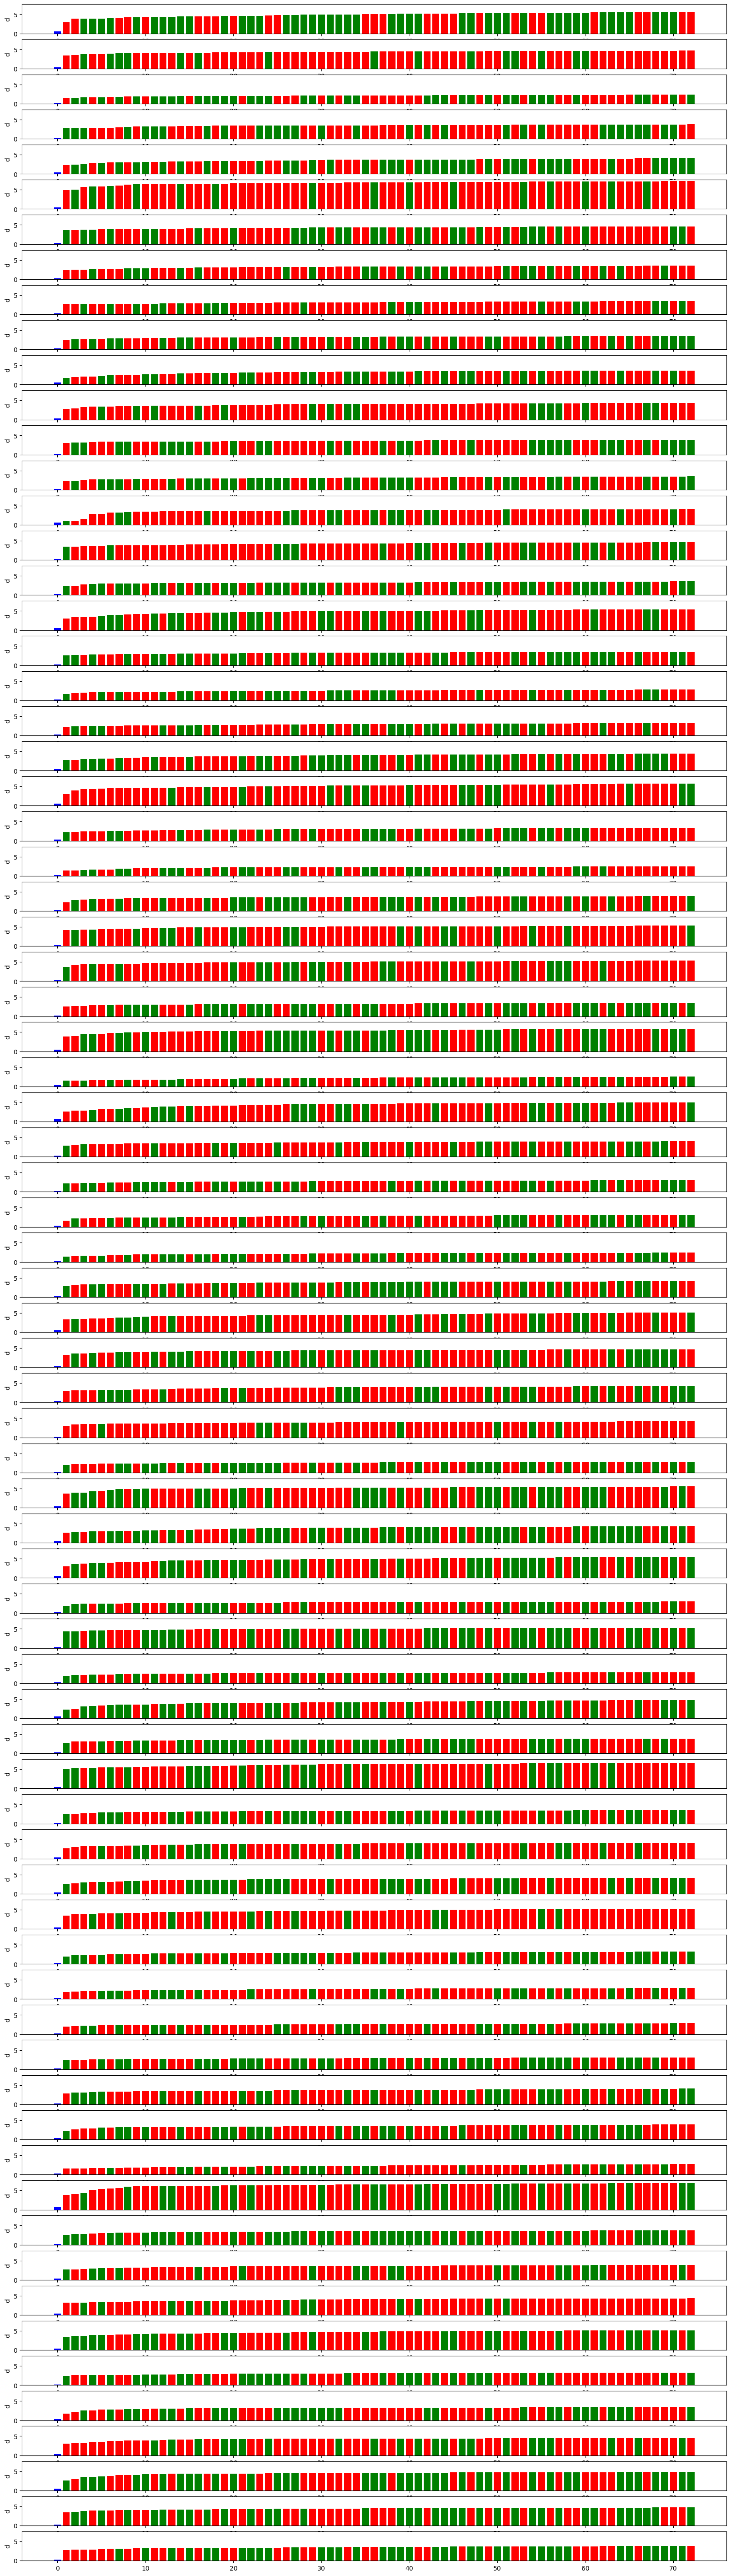

In [356]:
plot_neighbor_distances(Z_NON_IID, 5, 2)

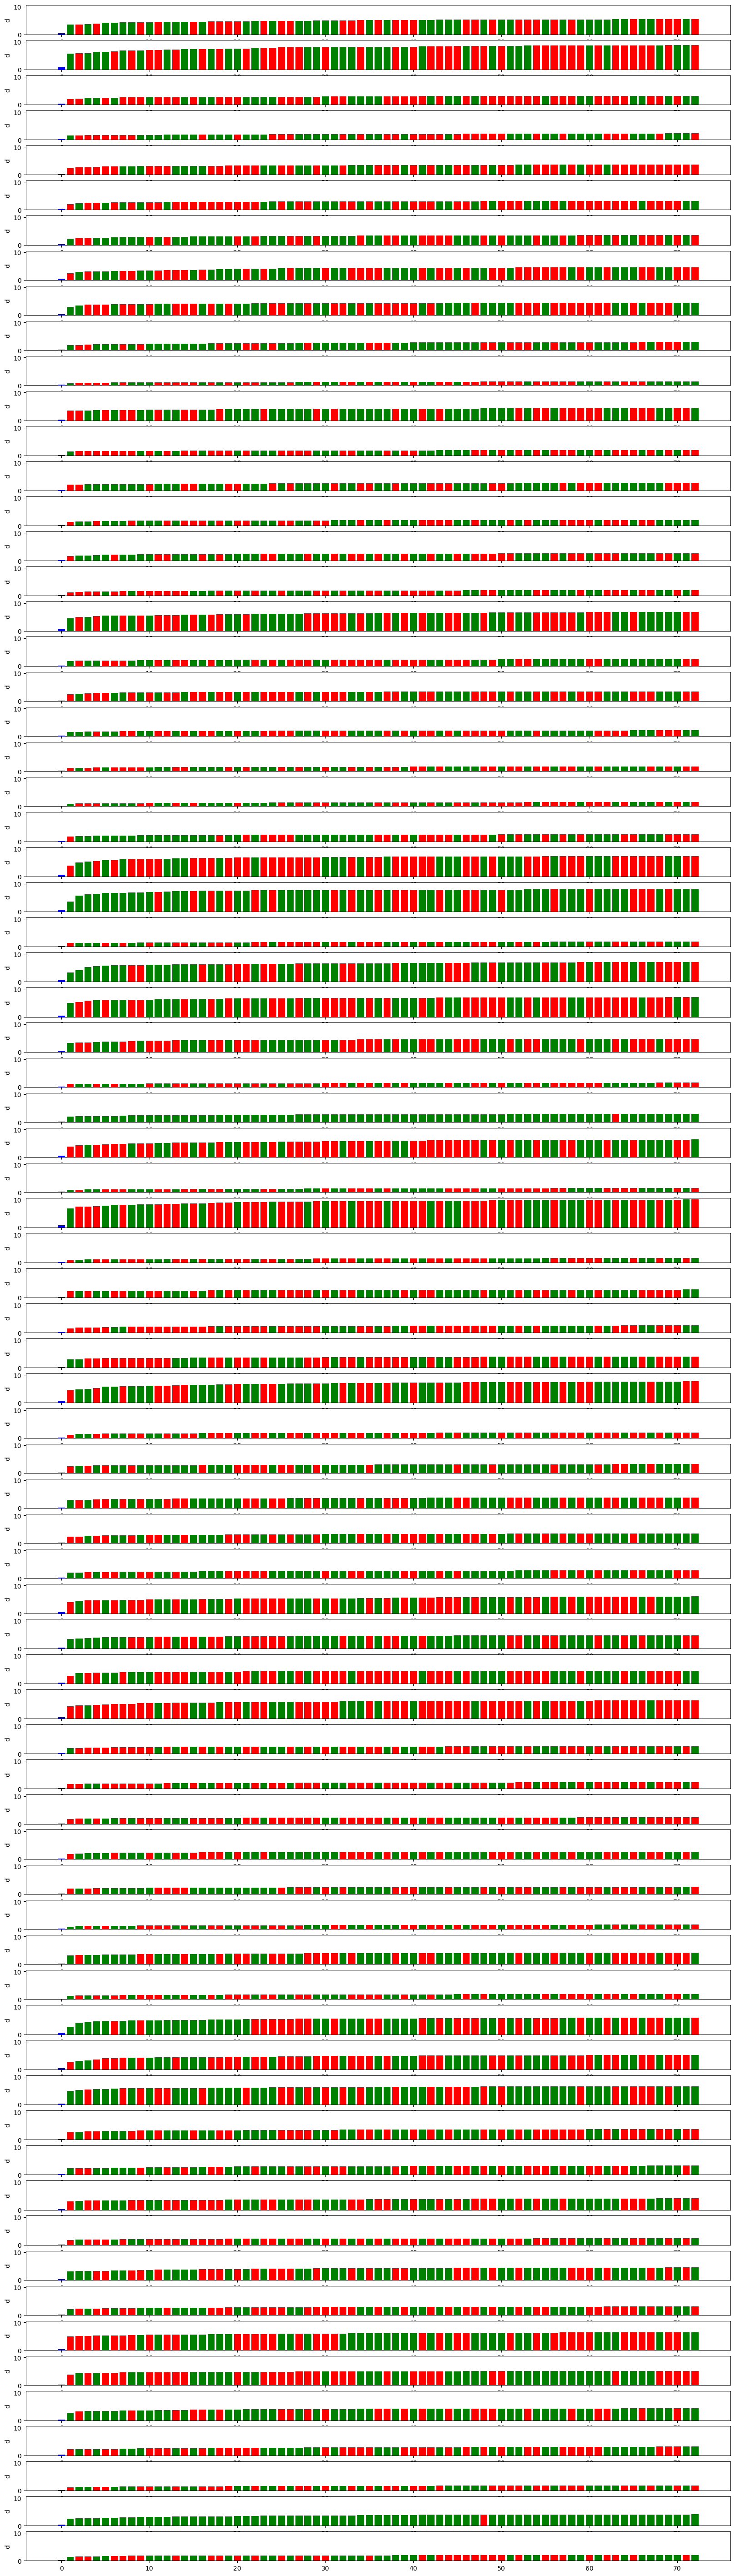

In [355]:
plot_neighbor_distances(Z_NON_IID, 5, 8)

In [73]:
bar_colors = bar_labels[bar_colors]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Experiment: KDE instead of k-NN

In [82]:
# Get Z for each epoch fast
def get_Z(epoch, client_id):
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == client_id) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    Y = np.array(df_t.label.to_list())
    C = np.array(df_t.client_id.to_list())
    
    p = KernelDensity(kernel='gaussian').fit(Z)
    P = np.exp(p.score_samples(Z))
    
    p_k = {}
    
    for k in range(Y.shape[1]):
        idx = Y[:, k] == 1
        if idx.sum() > 0:
            p_k[k] = KernelDensity(kernel='gaussian').fit(Z[idx])
            p_k[k] = np.exp(p_k[k].score_samples(Z))
        else:
            p_k[k] = np.zeros(Z.shape[0])
        
    P = np.array([p_k[k] for k in range(Y.shape[1])]).T
    
    return P, Y, C, epoch

def get_all_Z(epochs):
    Z_all = []
    for client_id in tqdm(range(num_clients)):
        Z_all.append({})
        partial_get_Z = partial(get_Z, client_id=client_id)
        with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count())) as p:
            for r in tqdm(p.imap_unordered(partial_get_Z, range(1, epochs + 1)), total=epochs, leave=True, position=0):
                Z_all[client_id][r[-1]] = r[:-1]
            
    return Z_all



In [135]:
# Get Z for each epoch fast
def get_Z(epoch):
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    Y = np.array(df_t.label.to_list())
    C = np.array(df_t.client_id.to_list())
    
    p_k = {}
    
    for k in range(Y.shape[1]):
        idx = Y[:, k] == 1
        p_k[k] = KernelDensity(kernel='gaussian').fit(Z[idx])
        
    p = KernelDensity(kernel='gaussian').fit(Z)
    P_all = np.exp(p.score_samples(Z))
    
    proportions = [np.mean(Y[:, k]) for k in range(Y.shape[1])]
    P = np.array([proportions[k] * np.exp(p_k[k].score_samples(Z)) for k in range(Y.shape[1])]).T
        
    P = np.array([np.exp(p_k[k].score_samples(Z)) for k in range(Y.shape[1])]).T
    
    return P, P_all, Y, C, epoch

def get_all_Z(epochs):
    Z_all = {}
    with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count())) as p:
        for r in tqdm(p.imap_unordered(get_Z, range(1, epochs + 1)), total=epochs):
            Z_all[r[-1]] = r[:-1]
            
    return Z_all

In [136]:
Z_NON_IID = get_all_Z(epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

In [109]:
def naive_bayes(theta, P, Y, C):
    P = P / P.T.sum(axis=1)
    
    mask = Y == 1
    P_k = (P * mask).sum(axis=1)
    P_k_ = (P * ~mask).sum(axis=1)
    
    #P_k_ = P - P_k
    P_k = P_k * theta
    P_k_ = P_k_ * (1 - theta)
    
    theta = P_k.sum() / (P_k_.sum() + P_k.sum())

    return theta


theta = np.array([0.3]*10)
num_clients = 10
Z_all = Z_NON_IID
# Z_all = Z_IID
df_probs = pd.DataFrame(columns=["epoch", "client_id", "prob_y0", "prob_y1"])
for epoch in tqdm(range(1, epochs + 1), total=epochs):
    for client_id in range(num_clients):
        theta[client_id] = naive_bayes(theta[client_id], *Z_all[client_id][epoch])
        df_probs.loc[len(df_probs)] = [epoch, client_id, theta[client_id], 1 - theta[client_id]]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: invalid value encountered in divide
  P = P / P.T.sum(axis=1)
/tmp/ipykernel_3379121/1806631952.py:2: RuntimeWarning: 

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

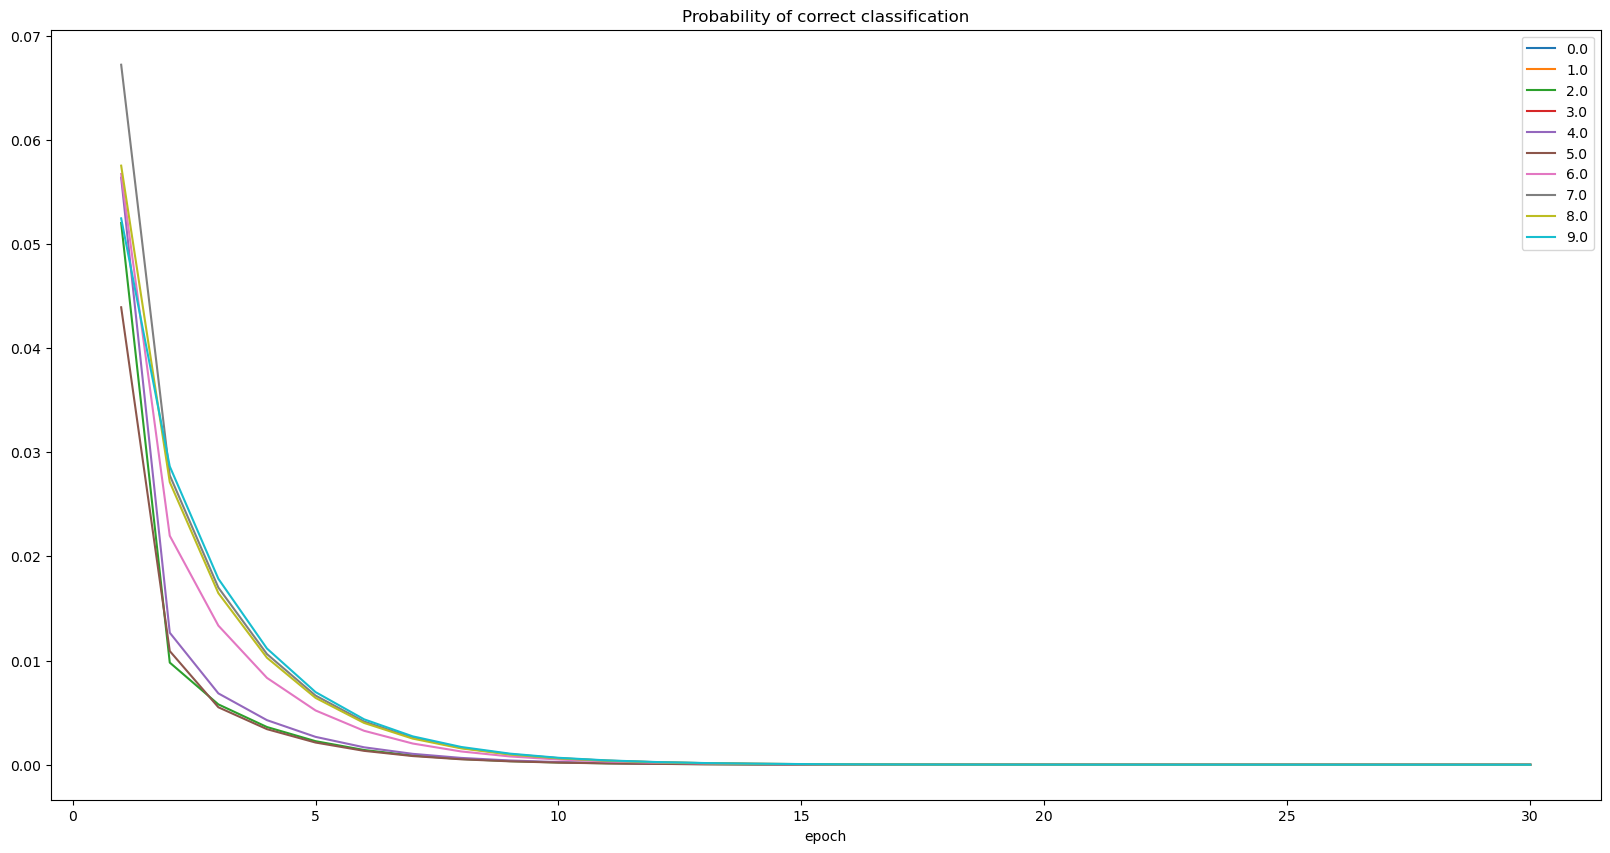

In [110]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

In [137]:
def naive_bayes(theta, P, P_all, Y, C):
    #P = P / Y.T.sum(axis=1)
    
    mask = Y == 1
    P_k = (P * mask).sum(axis=1)
    P_k_ = (P * ~mask).sum(axis=1)
    
    for client_id in range(theta.shape[0]):
            p_0_c, p_1_c = P_k[C == client_id], P_k_[C == client_id]
            p_0_c, p_1_c = p_0_c * theta[client_id], p_1_c * (1 - theta[client_id]) 
            theta[client_id] = (p_0_c.sum() / (p_0_c.sum() + p_1_c.sum()))

    return theta

theta = np.array([0.5]*10)
num_clients = 10
# Z_all = Z_IID
Z_all = Z_NON_IID
df_probs = pd.DataFrame(columns=["epoch", "client_id", "prob_y0", "prob_y1"])
for epoch in tqdm(range(1, epochs + 1), total=epochs):
    theta = naive_bayes(theta, *Z_all[epoch])
    for client_id in range(num_clients):
        df_probs.loc[len(df_probs)] = [epoch, client_id, theta[client_id], 1 - theta[client_id]]

  0%|          | 0/30 [00:00<?, ?it/s]

client_id
0.0    AxesSubplot(0.125,0.11;0.775x0.77)
1.0    AxesSubplot(0.125,0.11;0.775x0.77)
2.0    AxesSubplot(0.125,0.11;0.775x0.77)
3.0    AxesSubplot(0.125,0.11;0.775x0.77)
4.0    AxesSubplot(0.125,0.11;0.775x0.77)
5.0    AxesSubplot(0.125,0.11;0.775x0.77)
6.0    AxesSubplot(0.125,0.11;0.775x0.77)
7.0    AxesSubplot(0.125,0.11;0.775x0.77)
8.0    AxesSubplot(0.125,0.11;0.775x0.77)
9.0    AxesSubplot(0.125,0.11;0.775x0.77)
Name: prob_y0, dtype: object

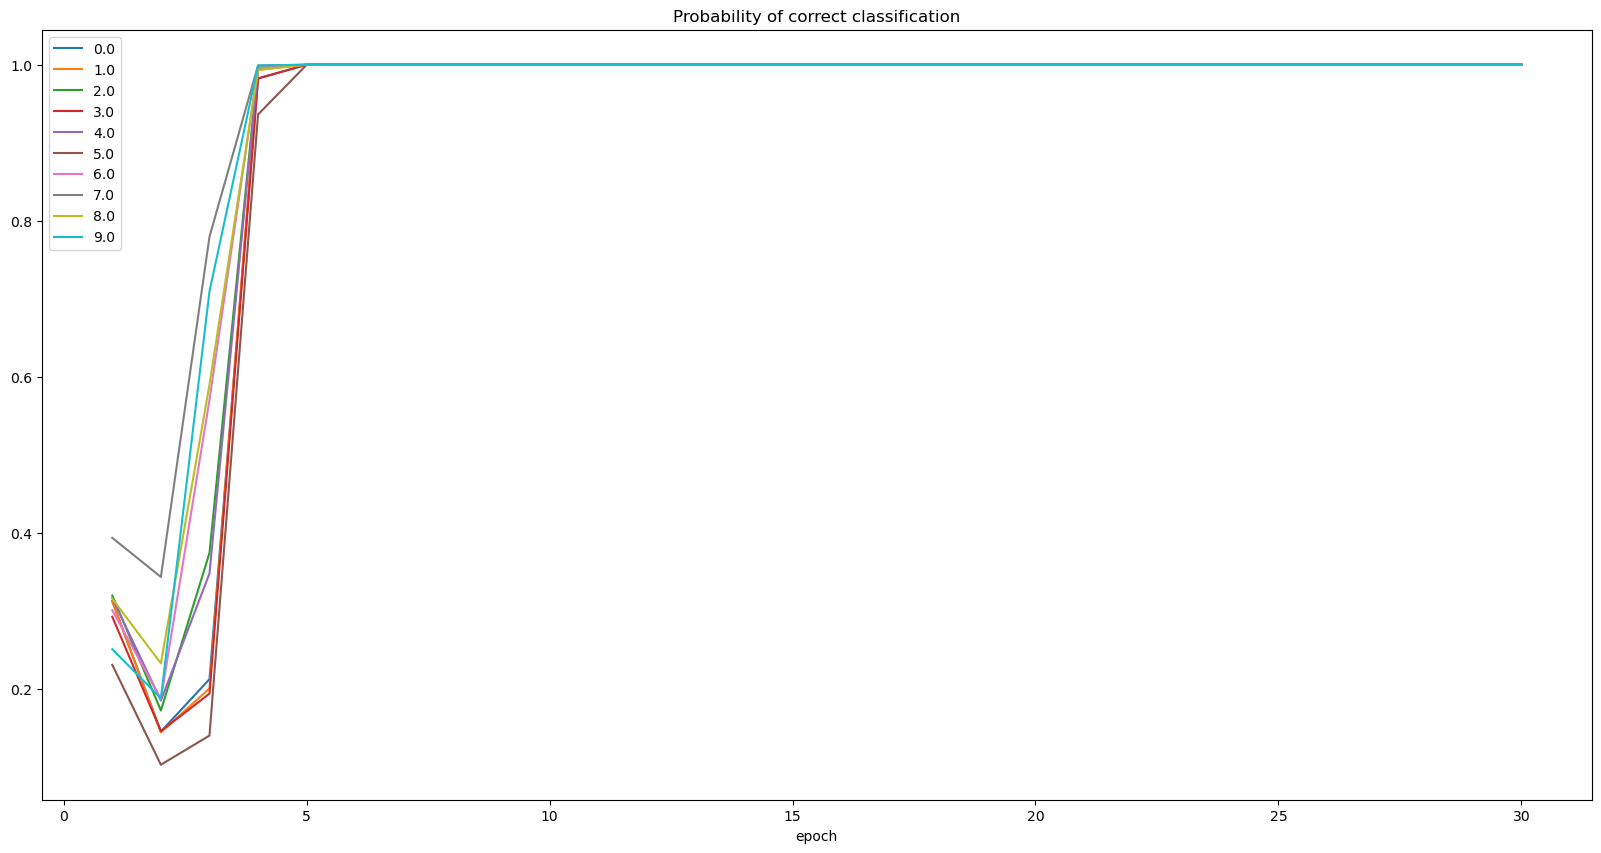

In [138]:
df_probs.set_index("epoch").groupby("client_id")["prob_y0"].plot(figsize=(20, 10), legend=True, title="Probability of correct classification")

In [134]:
e = 6
P, P_all, Y, C = Z_NON_IID[e]
mask = Y == 1
P_k = (P * mask).sum(axis=1)
P_k_ = (P * ~mask).sum(axis=1)

for c in range(num_clients):
    p, p_k, p_k_ = P_all[C == c], P_k[C == c], P_k_[C == c]
    #P_k_ = P - P_k  
    # P = P / P.sum()
    # P_k = P_k / P.sum()
    # P_k_ = P_k_ / P.sum()
    print( len(p_k), p - p_k, p_k_.sum())

704 [-4.02289370e-14 -2.00563687e-14 -2.00563687e-14 -2.00563687e-14
 -4.02289370e-14 -4.02289370e-14 -2.00563687e-14 -4.02289370e-14
 -4.02289370e-14 -4.02289370e-14 -4.02289370e-14 -2.00563687e-14
 -4.02289370e-14 -4.02289370e-14 -2.00563687e-14 -4.02289370e-14
 -4.02289370e-14 -4.02289370e-14 -4.02289370e-14 -4.02289370e-14
 -4.02289370e-14 -4.02289370e-14 -4.02289370e-14 -4.02289370e-14
 -4.02289408e-14 -4.02289370e-14 -2.00563687e-14 -4.02289356e-14
 -4.02289370e-14 -2.00563687e-14 -4.02289370e-14 -2.00563687e-14
 -2.00563687e-14 -4.02289370e-14 -4.02289370e-14 -4.02289370e-14
 -4.02289370e-14 -2.00563687e-14 -4.02289370e-14 -2.00563687e-14
 -2.00563539e-14 -2.00563687e-14 -4.02289370e-14 -2.00563687e-14
 -4.02289370e-14 -2.00563687e-14 -4.02289370e-14 -2.00563687e-14
 -4.02289370e-14 -2.00571892e-14 -2.00563687e-14 -2.00563687e-14
 -4.02289370e-14 -4.02289369e-14 -2.00563687e-14 -2.00563687e-14
 -4.02289370e-14 -2.00563687e-14 -4.02289370e-14 -4.02289370e-14
 -4.02302883e-14 -4.0

In [91]:
P.T.sum(axis=1)

array([2.64173383e-10, 2.64147157e-10, 2.64177836e-10, 2.64151023e-10,
       2.64148131e-10])

## Experiment: Attraction instead of KDE

In [ ]:
from scipy.spatial.distance import pdist, squareform

def attraction_probability(Z, sigma, metric=knn_params['metric']):
    """
    Compute attraction probabilities for each point with respect to all other points.
    
    Parameters:
        - Z: The sample space (data points).
        - Y: The labels.
        - sigma: The Gaussian variance parameter.
        - metric: The distance metric used for pdist. Default is 'euclidean'.
    
    Returns:
        A matrix P where P[i, j] is the attraction probability of point j to point i.
    """
    
    D = squareform(pdist(Z, metric=metric))
    D = D ** 2
    P = np.exp(-D / (2.0 * sigma**2))
    np.fill_diagonal(P, 0)
    
    # Normalize attraction probabilities
    P /= P.sum(axis=1, keepdims=True)
    
    return P

# Get Z for each epoch fast
def get_Z(epoch, client_id):
    # Let the epoch be t
    df_t = df_base[(df_base["epoch"] == epoch) & (df_base["client_id"] == client_id) & (df_base["stage"] == "train")].copy()
    df_t.client_output = pool_latent_vectors(df_t.client_output.to_list(), pooling=pooling).tolist()
    df_t = df_t.reset_index(drop=True)

    # Latent Space with labels and client_id for each sample
    Z = np.array(df_t.client_output.to_list())
    Y = np.array(df_t.label.to_list())
    
    P = 
    
    return P_k, P_k_, P, epoch

def get_all_Z(epochs):
    Z_all = []
    for client_id in tqdm(range(num_clients)):
        Z_all.append({})
        partial_get_Z = partial(get_Z, client_id=client_id)
        with closing(multiprocessing.Pool(processes=multiprocessing.cpu_count())) as p:
            for r in tqdm(p.imap_unordered(partial_get_Z, range(1, epochs + 1)), total=epochs, leave=True, position=0):
                Z_all[client_id][r[-1]] = r[:-1]
            
    return Z_all

In [144]:
import numpy as np



def class_choice_probability(Z, Y, sigma, metric='euclidean'):
    P = attraction_probability(Z, Y, sigma, metric)
    
    # Compute P_0 and P_1 for each point
    P_0 = np.array([P[i, Y == Y[i]].sum() for i in range(P.shape[0])])
    P_1 = np.array([P[i, Y != Y[i]].sum() for i in range(P.shape[0])])
    
    return P_0 / (P_0 + P_1)

# Sample data
Z = np.array([[1, 2], [2, 3], [1, 1], [4, 5], [5, 6]])
Y = np.array([0, 1, 0, 1, 0])
sigma = 1.0

probabilities = class_choice_probability(Z, Y, sigma, metric='euclidean')
print(probabilities)


[6.22380550e-01 3.91022683e-02 8.80792312e-01 4.74102656e-02
 3.09196769e-07]


## Experiment: Reference client (Random Sampling and Static Sampling)